**지역별 폐교를 활용한 노인 복지 시설 입지 선정:
연령별 인구수와의 상관관계 분석을 중심으로**


**프로젝트 목적:**

지역별 노인인구수, 노인인구 비율, 평균연령, 아동인구 비율과 폐교의 상관관계를 분석하여 폐교의 노인복지시설 전환으로의 근거 제시 및 최적 입지 선정

---

**사용 데이터:**
- 지방교육재정알리미_시도교육청 폐교재산형황 / 시도별 폐교목록(기준일자 2023.03.01)
- 국토지리정보원_행정경계-읍면동(Z_SOP_BND_ADM_DONG_PG), 시도(Z-NGII_N3A_G0010000)
- 주민등록 인구 통계
  - 주민등록 인구 및 세대현황(기준일자 2023.11)
  - 주민등록인구기타현황(고령 인구현황)(2018~2022)
  - 주민등록인구기타현황(아동청소년청 인구현황)(2023)
  - 주민등록인구기타현황(평균연령)(2023)


**사용 라이브러리**

**- pandas**: 데이터분석을 위한 라이브러리. 행과 열로 이루어진 데이터 객체를 다루기 위해 사용하며 대용량 데이를 효과적으로 처리할 수 있다.

**- geopandas**: pandas에 기반을 둔 라이브러리로 공간 데이터를 처리. 공간 정보를 가진 데이터프레임을 만들고 조작하기 위해 사용한다.

**- mapclassify**: 지리공간 데이터를 분류하기 위한 라이브러리. 다양한 통계적 분류 체계를 제공하여 지도 시각화를 지원한다.

**- numpy**: 대규모의 다차원 배열과 행렬 연산에 필요한 수학 함수를 제공하는 라이브러리.

**- matplotlib**: 데이터 시각화를 위한 라이브러리.

**- openpyxl**: xlsx/slsm/xltx/xltm 파일 읽고 쓰기를 지원하는 라이브러리.

**- seaborn**: matplolib 기반 그래픽 라이브러리로, 통계 시각화 기능을 제공한다.

**- satasmodels.api**: 통계적 모델링을 위한 라이브러리. 회귀분석, 시계열 분석 등의 통계 모델을 제공한다.

**- sklearn.preprocessing MinMaxScaler**: 사이킷런의 전처리 모듈로 특성 스케일링을 위해 사용. MinMaxScaler은 모든 특성이 정확히 0과 1 사이에 위치하도록 데이터를 조정한다.


In [ ]:
#라이브러리 임포트
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

 **데이터 전처리**

**시도교육청 별 폐교목록 데이터 전처리**

기존 파일 형식은 시도교육청, 폐교명, 폐교연도, 지역교육청, 급별, 활용현황, 주소로 구성되어 있다.

이 중 활용할 데이터인 시도교육청, 폐교명, 활용현황,
주소만 불러온 후, 주소에서 읍/면/동 정보만을 남겨 필요주소 열을 생성한다.

In [ ]:
closed_df = pd.read_excel("시도교육청_폐교목록_계.xlsx")[['시도교육청', '폐교명', '활용현황', '주소']]

#주소 열에서 마지막 단어가 읍, 면, 동일 경우에만 추출하여 '필요주소' 열을 새로 생성한다.
#읍, 면, 동을 키워드로 하여 추출할 경우 주소 중간에 읍, 면, 동이 들어갔을 경우도 추출하기 때문에 endswith을 활용하여
#마지막 단어가 읍, 면, 동일 경우에만 추출
closed_df['시군구'] = closed_df['주소'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(( '군', '구'))]))
closed_df['필요주소'] = closed_df['주소'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
print(closed_df)



/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


     시도교육청          폐교명  활용현황                  주소  시군구 필요주소
0       경기      (구) 고양중  자체활용          고양시 삼송동 45       삼송동
1       경기      (구) 군서초  자체활용      시흥시 정왕동 806-20       정왕동
2       경기      (구) 삼송초    대부          고양시 삼송동 62       삼송동
3       경기      (구) 상신초    대부     화성시 향남읍 상신리 874       향남읍
4       경기      (구) 화정초    대부     안산시 단원구 화정동 519  단원구  화정동
...    ...          ...   ...                 ...  ...  ...
3917    전남       흥산초등학교    매각      곡성군 겸면 괴정리 873  곡성군   겸면
3918    전남       흥양초등학교    대부   고흥 도화면 신호리 287-1        도화면
3919    강원    흥업초 사제분교장    대부     원주시 흥업면 사제리 534       흥업면
3920    인천          흥왕초  자체활용     강화군 화도면 흥왕리 361  강화군  화도면
3921    경북  흥해초등학교남송분교장    매각  포항시 북구 흥해읍 남송리 217   북구  흥해읍

[3922 rows x 6 columns]


In [ ]:
output_file_path = "시도별폐교목록_가공.xlsx"

# 데이터프레임을 Excel 파일로 저장
closed_df.to_excel(output_file_path, index=False)

In [ ]:
#각 지역별 폐교의 개수를 알기 위해 지역별 폐교의 개수를 합쳐 새로운 데이터프레임 생성
#읍, 면, 동 주소가 겹치는 경우가 있기때문에 '시도교육청'과 '필요주소'값이 모두 같은 경우에 대해서만 더하기 수행
closed_sum_df = closed_df.groupby(['시도교육청', '시군구','필요주소']).size().reset_index(name = '개수')
print(closed_sum_df)

     시도교육청  시군구    필요주소  개수
0       강원                1
1       강원          가곡면   1
2       강원          강동면   1
3       강원       강릉시왕산면   1
4       강원          구정면   1
...    ...  ...     ...  ..
1589    충북  흥덕구     내곡동   1
1590    충북  흥덕구     복대동   1
1591    충북  흥덕구     오송읍   1
1592    충북  흥덕구     옥산면   3
1593    충북  흥덕구     현암동   1

[1594 rows x 4 columns]


In [ ]:
#타 데이터프레임과의 병합 수행 시 편의를 위해 '시도교육청' 열의 이름을 '시도'로 변경
#필요주소 열에 공백이 존재하기 때문에 필요주소가 공백이 아닌 경우에 대해서만 closed_sum_df 재구성
closed_sum_df.rename(columns = {'시도교육청':'시도'}, inplace = True)
closed_sum_df = closed_sum_df[closed_sum_df['필요주소'] != '']
print(closed_sum_df)

      시도  시군구    필요주소  개수
1     강원          가곡면   1
2     강원          강동면   1
3     강원       강릉시왕산면   1
4     강원          구정면   1
5     강원          귀래면   3
...   ..  ...     ...  ..
1589  충북  흥덕구     내곡동   1
1590  충북  흥덕구     복대동   1
1591  충북  흥덕구     오송읍   1
1592  충북  흥덕구     옥산면   3
1593  충북  흥덕구     현암동   1

[1581 rows x 4 columns]


In [ ]:
output_file_path = "시도별폐교합_가공.xlsx"

# 데이터프레임을 Excel 파일로 저장
closed_sum_df.to_excel(output_file_path, index=False)

**지역별 인구현황 데이터 전처리**

- 지역별 인구현황 파일에서 행정기관, 총 인구수, 연령구간 별 인구수 중 0~19세, 65~100세 이상에 해당하는 열을 읽어옴(연령 구간은 5세 기준)

- 0 ~ 4세, 5 ~ 9세, 10 ~ 14세, 15 ~ 19세에 해당하는 열을 더한 값을 아동 인구로 설정

- 65 ~ 69세, 70세 ~ 74세, 75 ~ 79세, 80 ~ 84세, 85 ~ 89세, 90 ~ 94세, 95 ~ 99세, 100세 이상에 해당하는 열을 더한 값을 노인 인구로 설정

- 노인인구를 총 인구수로 나눈 값을 노인인구 비율, 아동인구를 총 인구수로 나눈 값을 아동인구 비율로 설정

- 행정 기관에서 읍, 면, 동에 해당하는 정보만 추출하여 필요주소로 설정

- 행정기관에서 키워드(서울특별시, 부산광역시, 경기도 등)에 해당하는 값을 추출하여 시도 열을 생성


- 전체 데이터프레임에서 사용할 데이터(필요주소, 노인인구, 아동인구, 노인인구비율, 아동인구비율, 시도)로 데이터프레임 재구성

In [ ]:
data = pd.read_excel("2023 지역별 인구현황.xlsx", header = 3)

#사용할 열의 인덱스 지정
use_data = [1, 2, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 24]

population_status_df = data.iloc[:, use_data]
population_status_df = population_status_df.dropna()

#아동인구 열 생성. 데이터에서 쉼표 제거->정수변환 후 더한 값
population_status_df['아동인구'] = population_status_df.iloc[:, 2:6].replace(',', '', regex=True).astype(int).sum(axis = 1)

#노인인구 열 생성. 데이터에서 쉼표 제거->정수변환 후 더한 값
population_status_df['노인인구'] = population_status_df.iloc[:, 6:15].replace(',', '', regex=True).astype(int).sum(axis = 1)

# 아동인구 비율 열을 생성한다. 아동인구/총인구수
population_status_df['아동인구비율'] = population_status_df['아동인구'] / population_status_df['총 거주자수'].str.replace(',', '').astype(int)

# 노인인구 비율 열을 생성한다. 노인인구/총인구수
population_status_df['노인인구비율'] = population_status_df['노인인구'] / population_status_df['총 거주자수'].str.replace(',', '').astype(int)

#필요주소 열을 생성
population_status_df['필요주소'] = population_status_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))

population_status_df['시군구'] = population_status_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(( '군', '구'))]))
#시도 열 생성
#키워드 리스트
keyword_list = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원특별자치도',
                '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

population_status_df['시도'] = ''

for keyword in keyword_list:
  population_status_df.loc[population_status_df['행정기관'].str.contains(keyword), '시도'] = keyword

#필요주소 열에서 공란("")이 있으면 NaN으로 변환
population_status_df['필요주소'].replace('', np.nan, inplace=True)

#NaN 값이 있는 행을 삭제
population_status_df.dropna(subset = ['필요주소'], inplace = True)

#데이터프레임 재구성
population_status_df = population_status_df[['행정기관','필요주소', '시군구','총 거주자수', '노인인구', '아동인구', '노인인구비율', '아동인구비율', '시도']]

print(population_status_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                  행정기관   필요주소  시군구  총 거주자수  노인인구  아동인구    노인인구비율    아동인구비율  \
2      서울특별시 종로구 청운효자동  청운효자동  종로구  11,232  2911  1683  0.259170  0.149840   
3        서울특별시 종로구 사직동    사직동  종로구   8,853  2474  1117  0.279453  0.126172   
4        서울특별시 종로구 삼청동    삼청동  종로구   2,208   791   247  0.358243  0.111866   
5        서울특별시 종로구 부암동    부암동  종로구   8,977  2543  1205  0.283279  0.134232   
6        서울특별시 종로구 평창동    평창동  종로구  17,099  5027  2522  0.293994  0.147494   
...                ...    ...  ...     ...   ...   ...       ...       ...   
3875  제주특별자치도 서귀포시 서홍동    서홍동       11,150  2461  2625  0.220717  0.235426   
3876  제주특별자치도 서귀포시 대륜동    대륜동       15,297  3865  2864  0.252664  0.187226   
3877  제주특별자치도 서귀포시 대천동    대천동       13,648  3220  2677  0.235932  0.196146   
3878  제주특별자치도 서귀포시 중문동    중문동       12,343  3042  2128  0.246455  0.172405   
3879  제주특별자치도 서귀포시 예래동    예래동        3,804  1388   433  0.364879  0.113828   

           시도  
2       서울특별시  
3       서울특별시  
4       서울특별시  

In [ ]:
population_status_df

,행정기관,필요주소,시군구,총 거주자수,노인인구,아동인구,노인인구비율,아동인구비율,시도
2,서울특별시 종로구 청운효자동,청운효자동,종로구,"11,232",2911,1683,0.259170,0.149840,서울특별시
3,서울특별시 종로구 사직동,사직동,종로구,"8,853",2474,1117,0.279453,0.126172,서울특별시
4,서울특별시 종로구 삼청동,삼청동,종로구,"2,208",791,247,0.358243,0.111866,서울특별시
5,서울특별시 종로구 부암동,부암동,종로구,"8,977",2543,1205,0.283279,0.134232,서울특별시
6,서울특별시 종로구 평창동,평창동,종로구,"17,099",5027,2522,0.293994,0.147494,서울특별시
...,...,...,...,...,...,...,...,...,...
3875,제주특별자치도 서귀포시 서홍동,서홍동,,"11,150",2461,2625,0.220717,0.235426,제주특별자치도
3876,제주특별자치도 서귀포시 대륜동,대륜동,,"15,297",3865,2864,0.252664,0.187226,제주특별자치도
3877,제주특별자치도 서귀포시 대천동,대천동,,"13,648",3220,2677,0.235932,0.196146,제주특별자치도
3878,제주특별자치도 서귀포시 중문동,중문동,,"12,343",3042,2128,0.246455,0.172405,제주특별자치도


타 데이터와의 통일을 위해 키워드를 지정된 값에 대응시켜 변경

In [ ]:
replace_dict = {
    '서울특별시': '서울', '부산광역시': '부산', '대구광역시': '대구', '인천광역시': '인천',
    '광주광역시': '광주', '대전광역시': '대전', '울산광역시': '울산', '세종특별자치시': '세종',
    '경기도': '경기', '강원특별자치도': '강원', '충청북도': '충북', '충청남도': '충남',
    '전라북도': '전북', '전라남도': '전남', '경상북도': '경북', '경상남도': '경남', '제주특별자치도': '제주'
}

population_status_df['시도'] = population_status_df['시도'].replace(replace_dict)
print(population_status_df)

                  행정기관   필요주소  시군구  총 거주자수  노인인구  아동인구    노인인구비율    아동인구비율  시도
2      서울특별시 종로구 청운효자동  청운효자동  종로구  11,232  2911  1683  0.259170  0.149840  서울
3        서울특별시 종로구 사직동    사직동  종로구   8,853  2474  1117  0.279453  0.126172  서울
4        서울특별시 종로구 삼청동    삼청동  종로구   2,208   791   247  0.358243  0.111866  서울
5        서울특별시 종로구 부암동    부암동  종로구   8,977  2543  1205  0.283279  0.134232  서울
6        서울특별시 종로구 평창동    평창동  종로구  17,099  5027  2522  0.293994  0.147494  서울
...                ...    ...  ...     ...   ...   ...       ...       ...  ..
3875  제주특별자치도 서귀포시 서홍동    서홍동       11,150  2461  2625  0.220717  0.235426  제주
3876  제주특별자치도 서귀포시 대륜동    대륜동       15,297  3865  2864  0.252664  0.187226  제주
3877  제주특별자치도 서귀포시 대천동    대천동       13,648  3220  2677  0.235932  0.196146  제주
3878  제주특별자치도 서귀포시 중문동    중문동       12,343  3042  2128  0.246455  0.172405  제주
3879  제주특별자치도 서귀포시 예래동    예래동        3,804  1388   433  0.364879  0.113828  제주

[3525 rows x 9 columns]


In [ ]:
output_file_path = "인구데이터_가공.xlsx"

# 데이터프레임을 Excel 파일로 저장
population_status_df.to_excel(output_file_path, index=False)

**연도별 지역별 고령인구현황 데이터 전처리**

In [ ]:
elder2018_df = pd.read_excel("2018년 지역별 고령인구현황.xlsx", header = 2)[['행정기관', '65세이상 전체']]

elder2018_df['필요주소'] = elder2018_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
elder2018_df['필요주소'].replace('', np.nan, inplace=True)
elder2018_df.dropna(subset = ['필요주소'], inplace = True)
elder2018_df.rename(columns = {'65세이상 전체':'2018노인인구'}, inplace = True)

keyword_list = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원특별자치도',
                '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

elder2018_df['시도'] = ''

for keyword in keyword_list:
  elder2018_df.loc[elder2018_df['행정기관'].str.contains(keyword), '시도'] = keyword

elder2018_df['시도'] = elder2018_df['시도'].replace(replace_dict)
elder2018_df = elder2018_df[['행정기관','시도', '필요주소', '2018노인인구']]

print(elder2018_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                  행정기관  시도   필요주소 2018노인인구
2      서울특별시 종로구 청운효자동  서울  청운효자동    2,145
3        서울특별시 종로구 사직동  서울    사직동    1,756
4        서울특별시 종로구 삼청동  서울    삼청동      622
5        서울특별시 종로구 부암동  서울    부암동    1,742
6        서울특별시 종로구 평창동  서울    평창동    3,140
...                ...  ..    ...      ...
3834  제주특별자치도 서귀포시 서홍동  제주    서홍동    1,339
3835  제주특별자치도 서귀포시 대륜동  제주    대륜동    2,039
3836  제주특별자치도 서귀포시 대천동  제주    대천동    1,725
3837  제주특별자치도 서귀포시 중문동  제주    중문동    1,732
3838  제주특별자치도 서귀포시 예래동  제주    예래동      833

[3502 rows x 4 columns]


In [ ]:
elder2019_df = pd.read_excel("2019년 지역별 고령인구현황.xlsx", header = 2)[['행정기관', '65세이상 전체']]

elder2019_df['필요주소'] = elder2019_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
elder2019_df['필요주소'].replace('', np.nan, inplace=True)
elder2019_df.dropna(subset = ['필요주소'], inplace = True)
elder2019_df.rename(columns = {'65세이상 전체':'2019노인인구'}, inplace = True)

keyword_list = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원특별자치도',
                '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

elder2019_df['시도'] = ''

for keyword in keyword_list:
  elder2019_df.loc[elder2019_df['행정기관'].str.contains(keyword), '시도'] = keyword

elder2019_df['시도'] = elder2019_df['시도'].replace(replace_dict)
elder2019_df = elder2019_df[['행정기관', '시도', '필요주소', '2019노인인구']]

print(elder2019_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                  행정기관  시도   필요주소 2019노인인구
2      서울특별시 종로구 청운효자동  서울  청운효자동    2,186
3        서울특별시 종로구 사직동  서울    사직동    1,764
4        서울특별시 종로구 삼청동  서울    삼청동      639
5        서울특별시 종로구 부암동  서울    부암동    1,746
6        서울특별시 종로구 평창동  서울    평창동    3,234
...                ...  ..    ...      ...
3816  제주특별자치도 서귀포시 서홍동  제주    서홍동    1,393
3817  제주특별자치도 서귀포시 대륜동  제주    대륜동    2,179
3818  제주특별자치도 서귀포시 대천동  제주    대천동    1,788
3819  제주특별자치도 서귀포시 중문동  제주    중문동    1,801
3820  제주특별자치도 서귀포시 예래동  제주    예래동      847

[3483 rows x 4 columns]


In [ ]:
elder2020_df = pd.read_excel("2020년 지역별 고령인구현황.xlsx", header = 2)[['행정기관', '65세이상 전체']]

elder2020_df['필요주소'] = elder2020_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
elder2020_df['필요주소'].replace('', np.nan, inplace=True)
elder2020_df.dropna(subset = ['필요주소'], inplace = True)
elder2020_df.rename(columns = {'65세이상 전체':'2020노인인구'}, inplace = True)

keyword_list = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원특별자치도',
                '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

elder2020_df['시도'] = ''

for keyword in keyword_list:
  elder2020_df.loc[elder2020_df['행정기관'].str.contains(keyword), '시도'] = keyword

elder2020_df['시도'] = elder2020_df['시도'].replace(replace_dict)
elder2020_df = elder2020_df[['행정기관','시도', '필요주소', '2020노인인구']]

print(elder2020_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                  행정기관  시도   필요주소 2020노인인구
2      서울특별시 종로구 청운효자동  서울  청운효자동    2,235
3        서울특별시 종로구 사직동  서울    사직동    1,830
4        서울특별시 종로구 삼청동  서울    삼청동      654
5        서울특별시 종로구 부암동  서울    부암동    1,826
6        서울특별시 종로구 평창동  서울    평창동    3,360
...                ...  ..    ...      ...
3839  제주특별자치도 서귀포시 서홍동  제주    서홍동    1,482
3840  제주특별자치도 서귀포시 대륜동  제주    대륜동    2,362
3841  제주특별자치도 서귀포시 대천동  제주    대천동    1,913
3842  제주특별자치도 서귀포시 중문동  제주    중문동    1,909
3843  제주특별자치도 서귀포시 예래동  제주    예래동      887

[3490 rows x 4 columns]


In [ ]:

elder2021_df = pd.read_excel("2021년 지역별 고령인구현황.xlsx", header = 2)[['행정기관', '65세이상 전체']]

elder2021_df['필요주소'] = elder2021_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
elder2021_df['필요주소'].replace('', np.nan, inplace=True)
elder2021_df.dropna(subset = ['필요주소'], inplace = True)
elder2021_df.rename(columns = {'65세이상 전체':'2021노인인구'}, inplace = True)

keyword_list = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원특별자치도',
                '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

elder2021_df['시도'] = ''

for keyword in keyword_list:
  elder2021_df.loc[elder2021_df['행정기관'].str.contains(keyword), '시도'] = keyword

elder2021_df['시도'] = elder2021_df['시도'].replace(replace_dict)
elder2021_df = elder2021_df[['행정기관','시도', '필요주소', '2021노인인구']]

print(elder2021_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                  행정기관  시도   필요주소 2021노인인구
2      서울특별시 종로구 청운효자동  서울  청운효자동    2,139
3        서울특별시 종로구 사직동  서울    사직동    1,760
4        서울특별시 종로구 삼청동  서울    삼청동      607
5        서울특별시 종로구 부암동  서울    부암동    1,798
6        서울특별시 종로구 평창동  서울    평창동    3,413
...                ...  ..    ...      ...
3855  제주특별자치도 서귀포시 서홍동  제주    서홍동    1,558
3856  제주특별자치도 서귀포시 대륜동  제주    대륜동    2,474
3857  제주특별자치도 서귀포시 대천동  제주    대천동    2,019
3858  제주특별자치도 서귀포시 중문동  제주    중문동    2,002
3859  제주특별자치도 서귀포시 예래동  제주    예래동      945

[3507 rows x 4 columns]


In [ ]:
elder2022_df = pd.read_excel("2022년 지역별 고령인구현황.xlsx", header = 2)[['행정기관', '65세이상 전체']]

elder2022_df['필요주소'] = elder2022_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
elder2022_df['필요주소'].replace('', np.nan, inplace=True)
elder2022_df.dropna(subset = ['필요주소'], inplace = True)
elder2022_df.rename(columns = {'65세이상 전체':'2022노인인구'}, inplace = True)

keyword_list = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원특별자치도',
                '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

elder2022_df['시도'] = ''

for keyword in keyword_list:
  elder2022_df.loc[elder2022_df['행정기관'].str.contains(keyword), '시도'] = keyword

elder2022_df['시도'] = elder2022_df['시도'].replace(replace_dict)
elder2022_df = elder2022_df[['행정기관','시도', '필요주소', '2022노인인구']]

print(elder2022_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                  행정기관  시도   필요주소 2022노인인구
2      서울특별시 종로구 청운효자동  서울  청운효자동    2,134
3        서울특별시 종로구 사직동  서울    사직동    1,775
4        서울특별시 종로구 삼청동  서울    삼청동      593
5        서울특별시 종로구 부암동  서울    부암동    1,812
6        서울특별시 종로구 평창동  서울    평창동    3,454
...                ...  ..    ...      ...
3865  제주특별자치도 서귀포시 서홍동  제주    서홍동    1,636
3866  제주특별자치도 서귀포시 대륜동  제주    대륜동    2,641
3867  제주특별자치도 서귀포시 대천동  제주    대천동    2,142
3868  제주특별자치도 서귀포시 중문동  제주    중문동    2,098
3869  제주특별자치도 서귀포시 예래동  제주    예래동      979

[3516 rows x 4 columns]


In [ ]:
yearly_elder = pd.merge(elder2018_df, elder2019_df, on=['행정기관','시도', '필요주소'], how='inner')
yearly_elder = pd.merge(yearly_elder, elder2020_df, on=[ '행정기관','시도', '필요주소'], how='inner')
yearly_elder = pd.merge(yearly_elder, elder2021_df, on=['행정기관','시도', '필요주소'], how='inner')
yearly_elder = pd.merge(yearly_elder, elder2022_df, on=['행정기관','시도', '필요주소'], how='inner')
yearly_elder = yearly_elder.dropna(how='any')
print(yearly_elder)

                  행정기관  시도   필요주소 2018노인인구 2019노인인구 2020노인인구 2021노인인구 2022노인인구
0      서울특별시 종로구 청운효자동  서울  청운효자동    2,145    2,186    2,235    2,139    2,134
1        서울특별시 종로구 사직동  서울    사직동    1,756    1,764    1,830    1,760    1,775
2        서울특별시 종로구 삼청동  서울    삼청동      622      639      654      607      593
3        서울특별시 종로구 부암동  서울    부암동    1,742    1,746    1,826    1,798    1,812
4        서울특별시 종로구 평창동  서울    평창동    3,140    3,234    3,360    3,413    3,454
...                ...  ..    ...      ...      ...      ...      ...      ...
3414  제주특별자치도 서귀포시 서홍동  제주    서홍동    1,339    1,393    1,482    1,558    1,636
3415  제주특별자치도 서귀포시 대륜동  제주    대륜동    2,039    2,179    2,362    2,474    2,641
3416  제주특별자치도 서귀포시 대천동  제주    대천동    1,725    1,788    1,913    2,019    2,142
3417  제주특별자치도 서귀포시 중문동  제주    중문동    1,732    1,801    1,909    2,002    2,098
3418  제주특별자치도 서귀포시 예래동  제주    예래동      833      847      887      945      979

[3419 rows x 8 columns]


In [ ]:
output_file_path = "지역별노인인구수변화.xlsx"

# 데이터프레임을 Excel 파일로 저장
yearly_elder.to_excel(output_file_path, index=False)

지역별 노인인구 변화율을 계산

In [ ]:
# 각 연도의 노인인구 수를 숫자형으로 변환
for year in range(2018, 2023):
    yearly_elder[str(year)+'노인인구'] = yearly_elder[str(year)+'노인인구'].str.replace(',', '').astype(int)

# 노인인구 변화율 계산
for year in range(2019, 2023):
    yearly_elder[str(year)+'노인인구변화율'] = yearly_elder[str(year)+'노인인구'] / yearly_elder[str(year-1)+'노인인구'] - 1

yearly_elder['2018-2022노인인구변화율'] = yearly_elder['2022노인인구'] / yearly_elder['2018노인인구'] - 1


In [ ]:
print(yearly_elder)

                  행정기관  시도   필요주소  2018노인인구  2019노인인구  2020노인인구  2021노인인구  \
0      서울특별시 종로구 청운효자동  서울  청운효자동      2145      2186      2235      2139   
1        서울특별시 종로구 사직동  서울    사직동      1756      1764      1830      1760   
2        서울특별시 종로구 삼청동  서울    삼청동       622       639       654       607   
3        서울특별시 종로구 부암동  서울    부암동      1742      1746      1826      1798   
4        서울특별시 종로구 평창동  서울    평창동      3140      3234      3360      3413   
...                ...  ..    ...       ...       ...       ...       ...   
3414  제주특별자치도 서귀포시 서홍동  제주    서홍동      1339      1393      1482      1558   
3415  제주특별자치도 서귀포시 대륜동  제주    대륜동      2039      2179      2362      2474   
3416  제주특별자치도 서귀포시 대천동  제주    대천동      1725      1788      1913      2019   
3417  제주특별자치도 서귀포시 중문동  제주    중문동      1732      1801      1909      2002   
3418  제주특별자치도 서귀포시 예래동  제주    예래동       833       847       887       945   

      2022노인인구  2019노인인구변화율  2020노인인구변화율  2021노인인구변화율  2022노인인구변화율  \
0    

In [ ]:
output_file_path = "지역별노인인구수변화.xlsx"

# 데이터프레임을 Excel 파일로 저장
yearly_elder.to_excel(output_file_path, index=False)

In [ ]:
yearly_elder = yearly_elder[['행정기관','시도', '필요주소', '2018-2022노인인구변화율']]


In [ ]:
output_file_path = "지역별노인인구수변화.xlsx"

# 데이터프레임을 Excel 파일로 저장
yearly_elder.to_excel(output_file_path, index=False)

In [ ]:
population_status_df = population_status_df.merge(yearly_elder, on=['행정기관', '필요주소', '시도'], how='outer')
print(population_status_df)

                 행정기관   필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율    아동인구비율  \
0     서울특별시 종로구 청운효자동  청운효자동  종로구  11,232  2911.0  1683.0  0.259170  0.149840   
1       서울특별시 종로구 사직동    사직동  종로구   8,853  2474.0  1117.0  0.279453  0.126172   
2       서울특별시 종로구 삼청동    삼청동  종로구   2,208   791.0   247.0  0.358243  0.111866   
3       서울특별시 종로구 부암동    부암동  종로구   8,977  2543.0  1205.0  0.283279  0.134232   
4       서울특별시 종로구 평창동    평창동  종로구  17,099  5027.0  2522.0  0.293994  0.147494   
...               ...    ...  ...     ...     ...     ...       ...       ...   
3715     경상북도 군위군 효령면    효령면  NaN     NaN     NaN     NaN       NaN       NaN   
3716     경상북도 군위군 부계면    부계면  NaN     NaN     NaN     NaN       NaN       NaN   
3717     경상북도 군위군 우보면    우보면  NaN     NaN     NaN     NaN       NaN       NaN   
3718     경상북도 군위군 의흥면    의흥면  NaN     NaN     NaN     NaN       NaN       NaN   
3719     경상북도 군위군 산성면    산성면  NaN     NaN     NaN     NaN       NaN       NaN   

      시도  2018-2022노인인구변화율 

**지역별 평균연령 데이터 전처리**


In [ ]:
avg_age_df = pd.read_excel("2023년 지역별 평균연령.xlsx", header =2 )[['행정기관', '평균연령']]
avg_age_df['필요주소'] = avg_age_df['행정기관'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))
avg_age_df['필요주소'].replace('', np.nan, inplace=True)
avg_age_df.dropna(subset = ['필요주소'], inplace = True)

print(avg_age_df.head(20))

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                     행정기관  평균연령         필요주소
3         서울특별시 종로구 청운효자동  45.0        청운효자동
4           서울특별시 종로구 사직동  46.2          사직동
5           서울특별시 종로구 삼청동  49.5          삼청동
6           서울특별시 종로구 부암동  46.4          부암동
7           서울특별시 종로구 평창동  46.2          평창동
8           서울특별시 종로구 무악동  44.5          무악동
9           서울특별시 종로구 교남동  43.7          교남동
10          서울특별시 종로구 가회동  47.6          가회동
11  서울특별시 종로구 종로1.2.3.4가동  50.0  종로1.2.3.4가동
12      서울특별시 종로구 종로5.6가동  45.9      종로5.6가동
13          서울특별시 종로구 이화동  45.5          이화동
14          서울특별시 종로구 혜화동  42.4          혜화동
15        서울특별시 종로구 창신제1동  51.1        창신제1동
16        서울특별시 종로구 창신제2동  50.6        창신제2동
17        서울특별시 종로구 창신제3동  46.8        창신제3동
18        서울특별시 종로구 숭인제1동  48.2        숭인제1동
19        서울특별시 종로구 숭인제2동  44.8        숭인제2동
21           서울특별시 중구 소공동  42.5          소공동
22           서울특별시 중구 회현동  51.4          회현동
23            서울특별시 중구 명동  50.5           명동


In [ ]:
population_status_df = population_status_df.merge(avg_age_df, on=['행정기관', '필요주소'], how='outer')

print(population_status_df)

                 행정기관   필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율    아동인구비율  \
0     서울특별시 종로구 청운효자동  청운효자동  종로구  11,232  2911.0  1683.0  0.259170  0.149840   
1       서울특별시 종로구 사직동    사직동  종로구   8,853  2474.0  1117.0  0.279453  0.126172   
2       서울특별시 종로구 삼청동    삼청동  종로구   2,208   791.0   247.0  0.358243  0.111866   
3       서울특별시 종로구 부암동    부암동  종로구   8,977  2543.0  1205.0  0.283279  0.134232   
4       서울특별시 종로구 평창동    평창동  종로구  17,099  5027.0  2522.0  0.293994  0.147494   
...               ...    ...  ...     ...     ...     ...       ...       ...   
3715     경상북도 군위군 효령면    효령면  NaN     NaN     NaN     NaN       NaN       NaN   
3716     경상북도 군위군 부계면    부계면  NaN     NaN     NaN     NaN       NaN       NaN   
3717     경상북도 군위군 우보면    우보면  NaN     NaN     NaN     NaN       NaN       NaN   
3718     경상북도 군위군 의흥면    의흥면  NaN     NaN     NaN     NaN       NaN       NaN   
3719     경상북도 군위군 산성면    산성면  NaN     NaN     NaN     NaN       NaN       NaN   

      시도  2018-2022노인인구변화율 

**shp 파일과 population_status_df 병합**

지도 시각화를 위해 shp 파일을 읽어온다.

행정경계(읍, 면, 동)을 가지는 Z_SOP_BND_ADM_DONG_PG.shp를 읽어와, 읍면동에 해당하는 ADM_CD를 대응하는 population_status_df와 병합한다.


In [ ]:
gdf_umd  = gpd.read_file("Z_SOP_BND_ADM_DONG_PG.shp", encoding = 'euc_kr')

In [ ]:
print(gdf_umd.head(20))

   BASE_DATE    ADM_CD       ADM_NM  \
0   20220630  11010530          사직동   
1   20220630  11010540          삼청동   
2   20220630  11010550          부암동   
3   20220630  11010560          평창동   
4   20220630  11010570          무악동   
5   20220630  11010580          교남동   
6   20220630  11010600          가회동   
7   20220630  11010610  종로1·2·3·4가동   
8   20220630  11010630      종로5·6가동   
9   20220630  11010640          이화동   
10  20220630  11010670         창신1동   
11  20220630  11010680         창신2동   
12  20220630  11010690         창신3동   
13  20220630  11010700         숭인1동   
14  20220630  11010710         숭인2동   
15  20220630  11010720        청운효자동   
16  20220630  11010730          혜화동   
17  20220630  11020520          소공동   
18  20220630  11020540          회현동   
19  20220630  11020550           명동   

                                             geometry  
0   POLYGON ((197632.447 452882.195, 197633.809 45...  
1   POLYGON ((198100.848 453465.558, 198102.580 45...  
2   POLYGON 

In [ ]:
korea_map = gdf_umd.copy()
korea_map.rename(columns = {'ADM_NM' : '필요주소'}, inplace = True)

**주소 형식 통일**

인구 정보를 담은 데이터들과, shp에 저잗된 읍면동 주소 형식이 다름을 확인할 수 있다.

[avg_age_df]

11  서울특별시 종로구 종로1.2.3.4가동  50.0  종로1.2.3.4가동

12      서울특별시 종로구 종로5.6가동  45.9      종로5.6가동

13          서울특별시 종로구 이화동  45.5          이화동

14          서울특별시 종로구 혜화동  42.4          혜화동

15        서울특별시 종로구 창신제1동  51.1        창신제1동

16        서울특별시 종로구 창신제2동  50.6        창신제2동

17        서울특별시 종로구 창신제3동  46.8        창신제3동

18        서울특별시 종로구 숭인제1동  48.2        숭인제1동

19        서울특별시 종로구 숭인제2동  44.8        숭인제2동

[gdf_umd]

7   20220630  11010610  종로1·2·3·4가동   
8   20220630  11010630      종로5·6가동   
9   20220630  11010640          이화동   
10  20220630  11010670         창신1동   
11  20220630  11010680         창신2동   
12  20220630  11010690         창신3동   
13  20220630  11010700         숭인1동   
14  20220630  11010710         숭인2동   
15  20220630  11010720        청운효자동   
16  20220630  11010730          혜화동   
17  20220630  11020520          소공동   
18  20220630  11020540          회현동   
19  20220630  11020550           명동   |


avg_age_df와 gdf_umd에서 사용하는 특수문자가 다르고, 창신동의 경우 avg_age_df에서는 창신제1동, gdf_umd에서는 창신1동으로 표기하고 있다.

두 데이터의 '필요주소'를 기준으로 통합을 진행하고자 하는데 주소 형식이 다르다면 다른 값으로 인식되어 병합 과정에서 오류가 발생한다. 따라서 두 데이터의 주소 표기 형식을 통일하는 전처리 과정이 필요하다.

두 데이터에서 특수문자를 모두 제거하고, 문제가 되는 '제'를 일괄제거하여 형식을 통일하였다.

In [ ]:
# population_status_df '필요주소'에서 특수문자, 공백, '제' 제거
population_status_df['필요주소'] = population_status_df['필요주소'].str.replace('[^A-Za-z0-9가-힣]', '') # 특수문자 및 공백 제거
population_status_df['필요주소'] = population_status_df['필요주소'].str.replace('제', '') # '제' 제거

# korea_map의 '필요주소'에서 특수문자, 공백, '제' 제거
korea_map['필요주소'] = korea_map['필요주소'].str.replace('[^A-Za-z0-9가-힣]', '') #
korea_map['필요주소'] = korea_map['필요주소'].str.replace('제', '') # '제' 제거


print(population_status_df.head(20))
print(korea_map.head(20))

                     행정기관      필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율  \
0         서울특별시 종로구 청운효자동     청운효자동  종로구  11,232  2911.0  1683.0  0.259170   
1           서울특별시 종로구 사직동       사직동  종로구   8,853  2474.0  1117.0  0.279453   
2           서울특별시 종로구 삼청동       삼청동  종로구   2,208   791.0   247.0  0.358243   
3           서울특별시 종로구 부암동       부암동  종로구   8,977  2543.0  1205.0  0.283279   
4           서울특별시 종로구 평창동       평창동  종로구  17,099  5027.0  2522.0  0.293994   
5           서울특별시 종로구 무악동       무악동  종로구   7,947  2103.0  1474.0  0.264628   
6           서울특별시 종로구 교남동       교남동  종로구   9,606  2286.0  1525.0  0.237976   
7           서울특별시 종로구 가회동       가회동  종로구   3,759  1137.0   452.0  0.302474   
8   서울특별시 종로구 종로1.2.3.4가동  종로1234가동  종로구   6,491  2335.0   372.0  0.359729   
9       서울특별시 종로구 종로5.6가동    종로56가동  종로구   5,295  1483.0   357.0  0.280076   
10          서울특별시 종로구 이화동       이화동  종로구   6,800  1876.0   479.0  0.275882   
11          서울특별시 종로구 혜화동       혜화동  종로구  15,740  3579.0  1709.0

<ipython-input-110-2d083e9cd100>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  population_status_df['필요주소'] = population_status_df['필요주소'].str.replace('[^A-Za-z0-9가-힣]', '') # 특수문자 및 공백 제거
<ipython-input-110-2d083e9cd100>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  korea_map['필요주소'] = korea_map['필요주소'].str.replace('[^A-Za-z0-9가-힣]', '') #


shp 파일에는 ADM_NM을 제외하곤 위치를 특정할 수 있는 키값이 부족하다(ADM_CD와 geometry가 있으나 이는 타 데이터와의 병합 시 키 값이 되기 힘듦)

읍면동은 고유값이 아니라 동일한 지역명을 가진 지역이 다수 존재하는데, shp파일로부터 이를 특정하기 힘들기 때문에 데이터프레임의 정렬 특징을 이용하여 병합을 진행하고자 한다.

인구 데이터는 서울부터 제주도까지의 순서로 정렬되어있고, 이는 shp 파일또한 마찬가지다. 따라서 여러개의 지역이 같은 지역명을 가지더라도 정렬된 순서에 따라 대응될 가능성이 높다는 것에서 착안하여, 데이터프레임에 순서를 나타내는 열을 추가하였다.

In [ ]:
# 각 데이터프레임에 순서를 나타내는 열 추가
population_status_df['order'] = population_status_df.groupby('필요주소').cumcount()
korea_map['order'] = korea_map.groupby('필요주소').cumcount()

print(population_status_df.head(20))
print(korea_map.head(20))

                     행정기관      필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율  \
0         서울특별시 종로구 청운효자동     청운효자동  종로구  11,232  2911.0  1683.0  0.259170   
1           서울특별시 종로구 사직동       사직동  종로구   8,853  2474.0  1117.0  0.279453   
2           서울특별시 종로구 삼청동       삼청동  종로구   2,208   791.0   247.0  0.358243   
3           서울특별시 종로구 부암동       부암동  종로구   8,977  2543.0  1205.0  0.283279   
4           서울특별시 종로구 평창동       평창동  종로구  17,099  5027.0  2522.0  0.293994   
5           서울특별시 종로구 무악동       무악동  종로구   7,947  2103.0  1474.0  0.264628   
6           서울특별시 종로구 교남동       교남동  종로구   9,606  2286.0  1525.0  0.237976   
7           서울특별시 종로구 가회동       가회동  종로구   3,759  1137.0   452.0  0.302474   
8   서울특별시 종로구 종로1.2.3.4가동  종로1234가동  종로구   6,491  2335.0   372.0  0.359729   
9       서울특별시 종로구 종로5.6가동    종로56가동  종로구   5,295  1483.0   357.0  0.280076   
10          서울특별시 종로구 이화동       이화동  종로구   6,800  1876.0   479.0  0.275882   
11          서울특별시 종로구 혜화동       혜화동  종로구  15,740  3579.0  1709.0

In [ ]:
order_rows = population_status_df[population_status_df['필요주소'].str.contains('금곡동')]
print(order_rows)
print("---------------------------------------------------------------------------------------------------")
order_rows = korea_map[korea_map['필요주소'].str.contains('금곡동')]
print(order_rows)

                 행정기관 필요주소  시군구  총 거주자수     노인인구    아동인구    노인인구비율    아동인구비율  \
524      부산광역시 북구 금곡동  금곡동   북구  35,804  13761.0  4172.0  0.384343  0.116523   
1211  경기도 수원시 권선구 금곡동  금곡동  권선구  44,025   8605.0  8618.0  0.195457  0.195752   
1285  경기도 성남시 분당구 금곡동  금곡동  분당구  26,923   7174.0  3808.0  0.266464  0.141440   
1491     경기도 남양주시 금곡동  금곡동       17,633   6937.0  1410.0  0.393410  0.079964   

      시도  2018-2022노인인구변화율  평균연령  order  
524   부산          0.240948  50.2      0  
1211  경기          0.296625  41.1      1  
1285  경기          0.179925  44.9      2  
1491  경기          0.228802  51.1      3  
---------------------------------------------------------------------------------------------------
     BASE_DATE    ADM_CD 필요주소  \
524   20220630  21080540  금곡동   
1204  20220630  31012650  금곡동   
1271  20220630  31023710  금곡동   
1474  20220630  31130530  금곡동   

                                               geometry  order  
524   POLYGON ((385259.865 199237.049, 385312.272 19...   

위처럼 같은 지역명을 가진 값은 0부터 차례로 순서값을 가지는 것을 확인할 수 있다.

In [ ]:
# '필요주소'와 'order'를 기준으로 ID만 병합
merged_df = pd.merge(population_status_df, korea_map[['필요주소', 'order', 'ADM_CD', 'geometry']], how='left', left_on=['필요주소','order'], right_on = ['필요주소','order'])
print(merged_df)
order_rows = merged_df[merged_df['필요주소'].str.contains('금곡동')]
print(order_rows)

                 행정기관   필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율    아동인구비율  \
0     서울특별시 종로구 청운효자동  청운효자동  종로구  11,232  2911.0  1683.0  0.259170  0.149840   
1       서울특별시 종로구 사직동    사직동  종로구   8,853  2474.0  1117.0  0.279453  0.126172   
2       서울특별시 종로구 삼청동    삼청동  종로구   2,208   791.0   247.0  0.358243  0.111866   
3       서울특별시 종로구 부암동    부암동  종로구   8,977  2543.0  1205.0  0.283279  0.134232   
4       서울특별시 종로구 평창동    평창동  종로구  17,099  5027.0  2522.0  0.293994  0.147494   
...               ...    ...  ...     ...     ...     ...       ...       ...   
3715     경상북도 군위군 효령면    효령면  NaN     NaN     NaN     NaN       NaN       NaN   
3716     경상북도 군위군 부계면    부계면  NaN     NaN     NaN     NaN       NaN       NaN   
3717     경상북도 군위군 우보면    우보면  NaN     NaN     NaN     NaN       NaN       NaN   
3718     경상북도 군위군 의흥면    의흥면  NaN     NaN     NaN     NaN       NaN       NaN   
3719     경상북도 군위군 산성면    산성면  NaN     NaN     NaN     NaN       NaN       NaN   

      시도  2018-2022노인인구변화율 

In [ ]:
nan_id_rows = merged_df[merged_df['ADM_CD'].isna()]
print(nan_id_rows)

                행정기관  필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율    아동인구비율  \
374   서울특별시 강남구 개포3동  개포3동  강남구  16,752  4794.0  2632.0  0.286175  0.157116   
1183    세종특별자치시  나성동   나성동       13,191   827.0  3428.0  0.062694  0.259874   
1185    세종특별자치시  어진동   어진동       11,120   751.0  2823.0  0.067536  0.253867   
1466     경기도 과천시 원문동   원문동       15,385  2973.0  3569.0  0.193240  0.231979   
1521    경기도 시흥시 거북섬동  거북섬동       10,349   649.0  1950.0  0.062711  0.188424   
...              ...   ...  ...     ...     ...     ...       ...       ...   
3715    경상북도 군위군 효령면   효령면  NaN     NaN     NaN     NaN       NaN       NaN   
3716    경상북도 군위군 부계면   부계면  NaN     NaN     NaN     NaN       NaN       NaN   
3717    경상북도 군위군 우보면   우보면  NaN     NaN     NaN     NaN       NaN       NaN   
3718    경상북도 군위군 의흥면   의흥면  NaN     NaN     NaN     NaN       NaN       NaN   
3719    경상북도 군위군 산성면   산성면  NaN     NaN     NaN     NaN       NaN       NaN   

      시도  2018-2022노인인구변화율  평균연령  order ADM_CD geom

In [ ]:
merged_df = merged_df.dropna(subset=['ADM_CD'])
print(merged_df)

                  행정기관   필요주소  시군구  총 거주자수    노인인구    아동인구    노인인구비율  \
0      서울특별시 종로구 청운효자동  청운효자동  종로구  11,232  2911.0  1683.0  0.259170   
1        서울특별시 종로구 사직동    사직동  종로구   8,853  2474.0  1117.0  0.279453   
2        서울특별시 종로구 삼청동    삼청동  종로구   2,208   791.0   247.0  0.358243   
3        서울특별시 종로구 부암동    부암동  종로구   8,977  2543.0  1205.0  0.283279   
4        서울특별시 종로구 평창동    평창동  종로구  17,099  5027.0  2522.0  0.293994   
...                ...    ...  ...     ...     ...     ...       ...   
3523  제주특별자치도 서귀포시 중문동    중문동       12,343  3042.0  2128.0  0.246455   
3524  제주특별자치도 서귀포시 예래동    예래동        3,804  1388.0   433.0  0.364879   
3525    서울특별시 강남구 일원2동   일원2동  NaN     NaN     NaN     NaN       NaN   
3526       경기도 하남시 풍산동    풍산동  NaN     NaN     NaN     NaN       NaN   
3527      경기도 양주시 회천4동   회천4동  NaN     NaN     NaN     NaN       NaN   

        아동인구비율  시도  2018-2022노인인구변화율  평균연령  order    ADM_CD  \
0     0.149840  서울         -0.005128  45.0      0  11010720   
1     0.1

In [ ]:
output_file_path = "데이터합본.xlsx"

# 데이터프레임을 Excel 파일로 저장
merged_df.to_excel(output_file_path, index=False)

**한글폰트 설치**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False #축의 음수 기호 표시

**지도 시각화**

In [ ]:
!pip install mapclassify

In [ ]:
sido_data = gpd.read_file("Z_NGII_N3A_G0010000.shp", encoding = "euc-kr")

print(sido_data.head(20))

                                 UFID        BJCD     NAME    DIVI      SCLS  \
0   100037806045G00110100000000000000  4200000000      강원도  HJD004  G0018112   
1   100037709020G00110100000000000001  4100000000      경기도  HJD004  G0018112   
2   100035810071G00110100000000000002  4800000000     경상남도  HJD004  G0018112   
3   100036811070G00110100000000000003  4700000000     경상북도  HJD004  G0018112   
4   100035616034G00110100000000000004  2900000000    광주광역시  HJD003  G0018112   
5   100035803063G00110100000000000005  2700000000    대구광역시  HJD003  G0018112   
6   100036710066G00110100000000000006  3000000000    대전광역시  HJD003  G0018112   
7   100035913013G00110100000000000007  2600000000    부산광역시  HJD003  G0018112   
8   100037608080G00110100000000000008  1100000000    서울특별시  HJD002  G0018112   
9   100036706071G00110100000000000009  3600000000  세종특별자치시  HJD005  G0018112   
10  100035905080G00110100000000000010  3100000000    울산광역시  HJD003  G0018112   
11  100037611013G00110100000000000011  2

In [ ]:
gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')
sido_gdf = gpd.GeoDataFrame(sido_data, geometry='geometry')


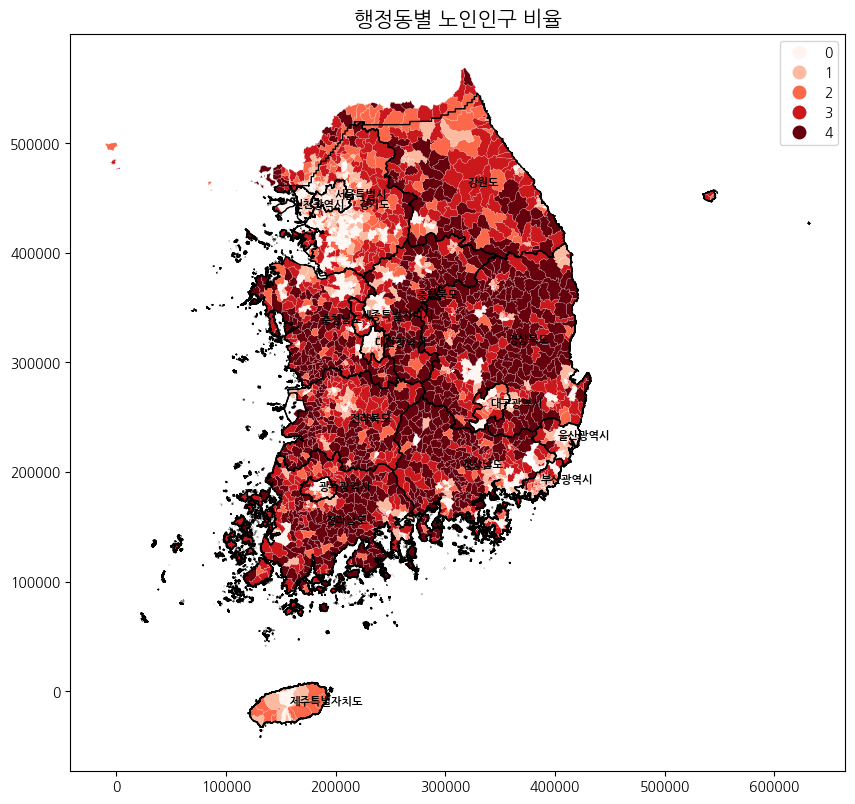

In [ ]:
import geopandas as gpd
import mapclassify as mc
import matplotlib.pyplot as plt

# GeoDataFrame 생성

# 시도 좌표계를 읍면동 좌표계와 같게 변환하기
sido_gdf = sido_gdf.to_crs(gdf.crs)


scheme = mc.Quantiles(gdf['노인인구비율'], k=5)

# 지도 시각화
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.assign(cl=scheme.yb).plot(column='cl', categorical=True, \
        cmap='Reds', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)


# 시도 경계 그리기
sido_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# 시도 이름 표시
for x, y, label in zip(sido_gdf.geometry.centroid.x, sido_gdf.geometry.centroid.y, sido_gdf['NAME']):
    ax.text(x, y, label, fontsize=8, fontweight='bold')

# 제목 설정
plt.title('행정동별 노인인구 비율', fontsize=15)

plt.show()

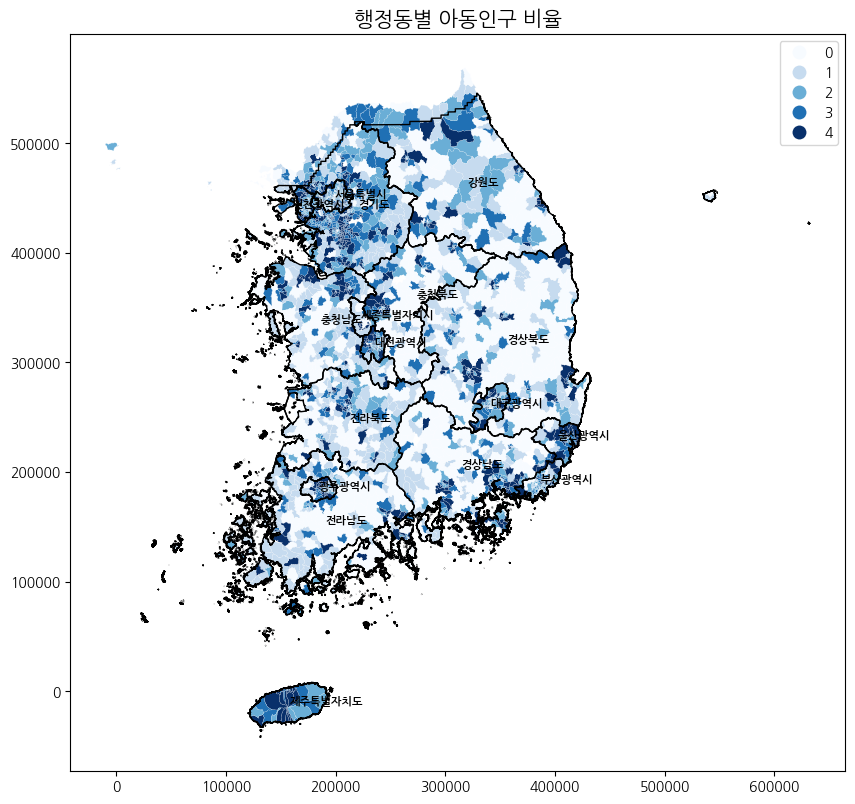

In [ ]:
scheme = mc.Quantiles(gdf['아동인구비율'], k=5)

# 지도 시각화
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.assign(cl=scheme.yb).plot(column='cl', categorical=True, \
        cmap='Blues', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

# 시도 경계 그리기
sido_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# 시도 이름 표시
for x, y, label in zip(sido_gdf.geometry.centroid.x, sido_gdf.geometry.centroid.y, sido_gdf['NAME']):
    ax.text(x, y, label, fontsize=8, fontweight='bold')

# 제목 설정
plt.title('행정동별 아동인구 비율', fontsize=15)

plt.show()

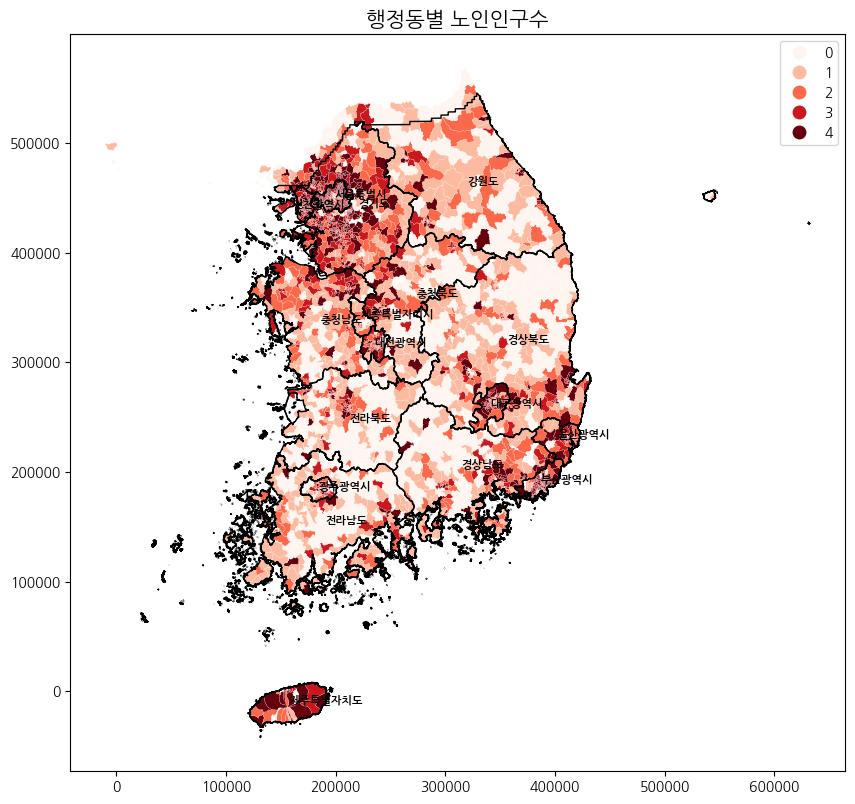

In [ ]:
scheme = mc.Quantiles(gdf['노인인구'], k=5)

# 지도 시각화
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.assign(cl=scheme.yb).plot(column='cl', categorical=True, \
        cmap='Reds', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

# 시도 경계 그리기
sido_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# 시도 이름 표시
for x, y, label in zip(sido_gdf.geometry.centroid.x, sido_gdf.geometry.centroid.y, sido_gdf['NAME']):
    ax.text(x, y, label, fontsize=8, fontweight='bold')

# 제목 설정
plt.title('행정동별 노인인구수', fontsize=15)

plt.show()

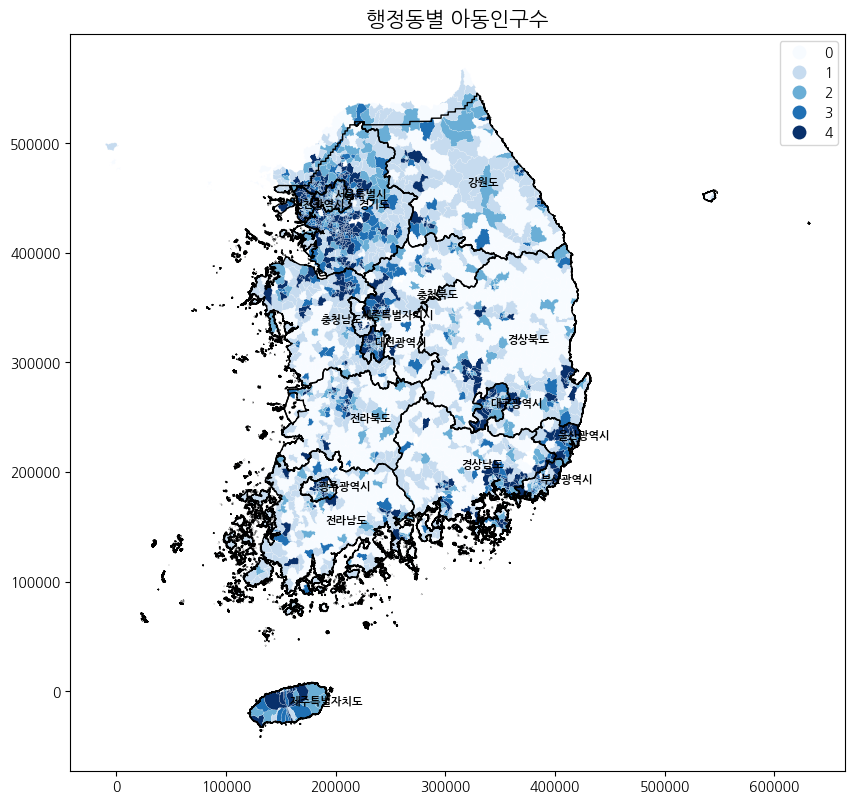

In [ ]:
scheme = mc.Quantiles(gdf['아동인구'], k=5)

# 지도 시각화
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.assign(cl=scheme.yb).plot(column='cl', categorical=True, \
        cmap='Blues', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

# 시도 경계 그리기
sido_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# 시도 이름 표시
for x, y, label in zip(sido_gdf.geometry.centroid.x, sido_gdf.geometry.centroid.y, sido_gdf['NAME']):
    ax.text(x, y, label, fontsize=8, fontweight='bold')

# 제목 설정
plt.title('행정동별 아동인구수', fontsize=15)

plt.show()

close_sum_df와 merged_df 병합

In [ ]:
closed_popul_merged = closed_sum_df.merge(merged_df, on = ['시도', '시군구', '필요주소'], how = 'outer')
closed_popul_merged['개수'].fillna(0, inplace = True)

closed_popul_merged

,시도,시군구,필요주소,개수,행정기관,총 거주자수,노인인구,아동인구,노인인구비율,아동인구비율,2018-2022노인인구변화율,평균연령,order,ADM_CD,geometry
0,강원,,가곡면,1.0,강원특별자치도 삼척시 가곡면,668,417.0,34.0,0.624251,0.050898,NaN,61.9,0.0,32070350,"POLYGON ((393701.795 413370.265, 393711.539 41..."
1,강원,,강동면,1.0,강원특별자치도 강릉시 강동면,"3,942",2142.0,222.0,0.543379,0.056317,NaN,57.7,0.0,32030340,"MULTIPOLYGON (((381420.991 464022.541, 381418...."
2,강원,,강릉시왕산면,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,강원,,구정면,1.0,강원특별자치도 강릉시 구정면,"4,236",1960.0,492.0,0.462701,0.116147,NaN,53.3,0.0,32030330,"POLYGON ((363740.856 471708.115, 363753.416 47..."
4,강원,,귀래면,3.0,강원특별자치도 원주시 귀래면,"2,081",1293.0,90.0,0.621336,0.043248,NaN,60.7,0.0,32020350,"POLYGON ((277230.209 416346.425, 277248.598 41..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892,제주,,중문동,0.0,제주특별자치도 서귀포시 중문동,"12,343",3042.0,2128.0,0.246455,0.172405,0.211316,43.8,0.0,39020610,"POLYGON ((150191.317 -15003.098, 150300.388 -1..."
3893,제주,,예래동,0.0,제주특별자치도 서귀포시 예래동,"3,804",1388.0,433.0,0.364879,0.113828,0.175270,49.9,0.0,39020620,"MULTIPOLYGON (((141492.097 -29482.807, 141490...."
3894,서울,NaN,일원2동,0.0,서울특별시 강남구 일원2동,NaN,NaN,NaN,NaN,NaN,0.380823,NaN,0.0,11230740,"POLYGON ((207303.571 444195.370, 207312.186 44..."
3895,경기,NaN,풍산동,0.0,경기도 하남시 풍산동,NaN,NaN,NaN,NaN,NaN,0.821039,NaN,1.0,31180610,"POLYGON ((217104.384 450876.550, 217108.894 45..."


In [ ]:
# 결측치가 있는 행을 확인
missing_rows = closed_popul_merged[closed_popul_merged.isnull().any(axis=1)]

print(missing_rows.head(50))

# 결측치가 있는 행의 개수를 확인
missing_rows_count = closed_popul_merged.isnull().any(axis=1).sum()

print(f"결측치가 존재하는 행의 개수: {missing_rows_count}")

    시도 시군구    필요주소   개수              행정기관  총 거주자수    노인인구    아동인구    노인인구비율  \
0   강원         가곡면  1.0   강원특별자치도 삼척시 가곡면     668   417.0    34.0  0.624251   
1   강원         강동면  1.0   강원특별자치도 강릉시 강동면   3,942  2142.0   222.0  0.543379   
2   강원      강릉시왕산면  1.0               NaN     NaN     NaN     NaN       NaN   
3   강원         구정면  1.0   강원특별자치도 강릉시 구정면   4,236  1960.0   492.0  0.462701   
4   강원         귀래면  3.0   강원특별자치도 원주시 귀래면   2,081  1293.0    90.0  0.621336   
5   강원         근덕면  7.0   강원특별자치도 삼척시 근덕면   4,895  2861.0   230.0  0.584474   
6   강원         금천동  1.0               NaN     NaN     NaN     NaN       NaN   
7   강원          남면  5.0    강원특별자치도 춘천시 남면   1,063   669.0    43.0  0.629351   
8   강원         남산면  2.0   강원특별자치도 춘천시 남산면   3,313  1849.0   183.0  0.558104   
9   강원         노곡면  5.0   강원특별자치도 삼척시 노곡면     687   467.0    17.0  0.679767   
10  강원         도경동  1.0               NaN     NaN     NaN     NaN       NaN   
11  강원         도계읍  8.0   강원특별자치도 삼척시 도계읍   9,281  3

In [ ]:
closed_popul_merged['2018-2022노인인구변화율'] = closed_popul_merged['2018-2022노인인구변화율'].fillna(0)
closed_popul_merged = closed_popul_merged.dropna()
print(closed_popul_merged)

      시도 시군구 필요주소   개수              행정기관  총 거주자수    노인인구    아동인구    노인인구비율  \
0     강원      가곡면  1.0   강원특별자치도 삼척시 가곡면     668   417.0    34.0  0.624251   
1     강원      강동면  1.0   강원특별자치도 강릉시 강동면   3,942  2142.0   222.0  0.543379   
3     강원      구정면  1.0   강원특별자치도 강릉시 구정면   4,236  1960.0   492.0  0.462701   
4     강원      귀래면  3.0   강원특별자치도 원주시 귀래면   2,081  1293.0    90.0  0.621336   
5     강원      근덕면  7.0   강원특별자치도 삼척시 근덕면   4,895  2861.0   230.0  0.584474   
...   ..  ..  ...  ...               ...     ...     ...     ...       ...   
3889  제주      서홍동  0.0  제주특별자치도 서귀포시 서홍동  11,150  2461.0  2625.0  0.220717   
3890  제주      대륜동  0.0  제주특별자치도 서귀포시 대륜동  15,297  3865.0  2864.0  0.252664   
3891  제주      대천동  0.0  제주특별자치도 서귀포시 대천동  13,648  3220.0  2677.0  0.235932   
3892  제주      중문동  0.0  제주특별자치도 서귀포시 중문동  12,343  3042.0  2128.0  0.246455   
3893  제주      예래동  0.0  제주특별자치도 서귀포시 예래동   3,804  1388.0   433.0  0.364879   

        아동인구비율  2018-2022노인인구변화율  평균연령  order    ADM_CD  \
0   

In [ ]:
closed_popul_merged

,시도,시군구,필요주소,개수,행정기관,총 거주자수,노인인구,아동인구,노인인구비율,아동인구비율,2018-2022노인인구변화율,평균연령,order,ADM_CD,geometry
0,강원,,가곡면,1.0,강원특별자치도 삼척시 가곡면,668,417.0,34.0,0.624251,0.050898,0.000000,61.9,0.0,32070350,"POLYGON ((393701.795 413370.265, 393711.539 41..."
1,강원,,강동면,1.0,강원특별자치도 강릉시 강동면,"3,942",2142.0,222.0,0.543379,0.056317,0.000000,57.7,0.0,32030340,"MULTIPOLYGON (((381420.991 464022.541, 381418...."
3,강원,,구정면,1.0,강원특별자치도 강릉시 구정면,"4,236",1960.0,492.0,0.462701,0.116147,0.000000,53.3,0.0,32030330,"POLYGON ((363740.856 471708.115, 363753.416 47..."
4,강원,,귀래면,3.0,강원특별자치도 원주시 귀래면,"2,081",1293.0,90.0,0.621336,0.043248,0.000000,60.7,0.0,32020350,"POLYGON ((277230.209 416346.425, 277248.598 41..."
5,강원,,근덕면,7.0,강원특별자치도 삼척시 근덕면,"4,895",2861.0,230.0,0.584474,0.046987,0.000000,60.4,0.0,32070310,"MULTIPOLYGON (((405736.683 422647.015, 405734...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3889,제주,,서홍동,0.0,제주특별자치도 서귀포시 서홍동,"11,150",2461.0,2625.0,0.220717,0.235426,0.221807,41.2,0.0,39020580,"POLYGON ((156174.259 -19690.338, 156196.680 -1..."
3890,제주,,대륜동,0.0,제주특별자치도 서귀포시 대륜동,"15,297",3865.0,2864.0,0.252664,0.187226,0.295243,43.6,0.0,39020590,"MULTIPOLYGON (((154707.423 -30954.652, 154706...."
3891,제주,,대천동,0.0,제주특별자치도 서귀포시 대천동,"13,648",3220.0,2677.0,0.235932,0.196146,0.241739,42.6,0.0,39020600,"MULTIPOLYGON (((153587.200 -29968.031, 153585...."
3892,제주,,중문동,0.0,제주특별자치도 서귀포시 중문동,"12,343",3042.0,2128.0,0.246455,0.172405,0.211316,43.8,0.0,39020610,"POLYGON ((150191.317 -15003.098, 150300.388 -1..."


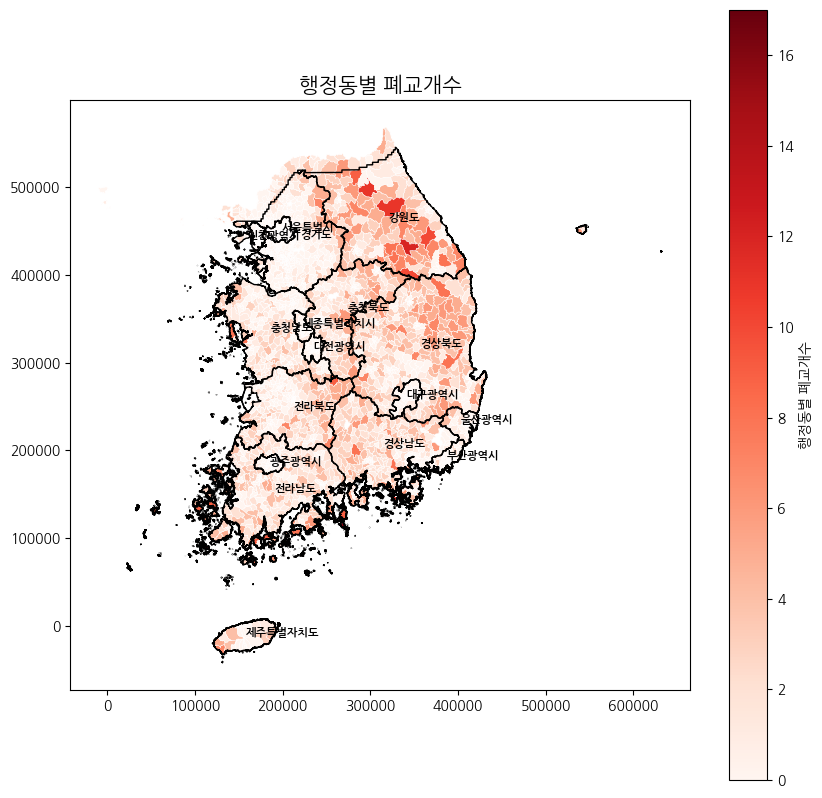

In [ ]:
gdf = gpd.GeoDataFrame(closed_popul_merged, geometry='geometry')
sido_gdf = gpd.GeoDataFrame(sido_data, geometry='geometry')

# 시도 좌표계를 읍면동 좌표계와 같게 변환하기
sido_gdf = sido_gdf.to_crs(gdf.crs)



fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # figsize 인자 추가
gdf.plot(column='개수', cmap='Reds', linewidth=0.3, ax=ax, edgecolor='1', legend=True,
         legend_kwds={'label': "행정동별 폐교개수", 'orientation': "vertical"})


# 시도 경계 그리기
sido_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# 시도 이름 표시
for x, y, label in zip(sido_gdf.geometry.centroid.x, sido_gdf.geometry.centroid.y, sido_gdf['NAME']):
    ax.text(x, y, label, fontsize=8, fontweight='bold')

# 제목 설정
plt.title('행정동별 폐교개수', fontsize=15)

plt.show()

노인인구, 아동인구, 노인인구비율, 아동인구비율 정규화


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
closed_popul_merged[['노인인구비율', '아동인구비율']] = scaler.fit_transform(closed_popul_merged[['노인인구비율', '아동인구비율']])

closed_popul_merged[['노인인구', '아동인구']] = scaler.fit_transform(closed_popul_merged[['노인인구', '아동인구']])

#closed_popul_merged[['2018-2022노인인구변화율']] = scaler.fit_transform(closed_popul_merged[['2018-2022노인인구변화율']])
print(closed_popul_merged)

<ipython-input-131-4924d2207c75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_popul_merged[['노인인구비율', '아동인구비율']] = scaler.fit_transform(closed_popul_merged[['노인인구비율', '아동인구비율']])
<ipython-input-131-4924d2207c75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_popul_merged[['노인인구', '아동인구']] = scaler.fit_transform(closed_popul_merged[['노인인구', '아동인구']])


      시도 시군구 필요주소   개수              행정기관  총 거주자수      노인인구      아동인구  \
0     강원      가곡면  1.0   강원특별자치도 삼척시 가곡면     668  0.013844  0.001168   
1     강원      강동면  1.0   강원특별자치도 강릉시 강동면   3,942  0.071111  0.008031   
3     강원      구정면  1.0   강원특별자치도 강릉시 구정면   4,236  0.065069  0.017888   
4     강원      귀래면  3.0   강원특별자치도 원주시 귀래면   2,081  0.042925  0.003212   
5     강원      근덕면  7.0   강원특별자치도 삼척시 근덕면   4,895  0.094980  0.008323   
...   ..  ..  ...  ...               ...     ...       ...       ...   
3889  제주      서홍동  0.0  제주특별자치도 서귀포시 서홍동  11,150  0.081701  0.095754   
3890  제주      대륜동  0.0  제주특별자치도 서귀포시 대륜동  15,297  0.128312  0.104479   
3891  제주      대천동  0.0  제주특별자치도 서귀포시 대천동  13,648  0.106899  0.097653   
3892  제주      중문동  0.0  제주특별자치도 서귀포시 중문동  12,343  0.100989  0.077611   
3893  제주      예래동  0.0  제주특별자치도 서귀포시 예래동   3,804  0.046079  0.015734   

        노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order    ADM_CD  \
0     0.821542  0.061717          0.000000  61.9    0.0  32070350 

In [ ]:
df_sorted = closed_popul_merged.sort_values(by='개수', ascending=False)

print(df_sorted)

      시도  시군구   필요주소    개수              행정기관 총 거주자수      노인인구      아동인구  \
1149  전남  진도군    조도면  17.0      전라남도 진도군 조도면  2,153  0.038344  0.006498   
876   전남          남면  16.0       전라남도 여수시 남면  2,707  0.057433  0.005366   
305   경남         한산면  14.0      경상남도 통영시 한산면  1,867  0.040701  0.001935   
1010  전남         화정면  14.0      전라남도 여수시 화정면  1,293  0.030111  0.001059   
281   경남         욕지면  13.0      경상남도 통영시 욕지면  1,893  0.033165  0.003432   
...   ..  ...    ...   ...               ...    ...       ...       ...   
2354  인천   동구   화수2동   0.0     인천광역시 동구 화수2동  7,063  0.100292  0.025006   
2355  인천   동구  송현12동   0.0   인천광역시 동구 송현1.2동  9,868  0.103413  0.050414   
2356  인천   동구   송현3동   0.0     인천광역시 동구 송현3동  2,902  0.043025  0.007630   
2357  인천   동구   송림1동   0.0     인천광역시 동구 송림1동  6,465  0.049300  0.033074   
3893  제주         예래동   0.0  제주특별자치도 서귀포시 예래동  3,804  0.046079  0.015734   

        노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order    ADM_CD  \
1149  0.706006  0.130048      

**피어슨 상관관계 분석**

변수들간의 선형적 관계를 분석하고자 함으로, 피어슨 상관관계 분석을 사용함

결과분석

1. 개수, 아동인구비율 : 상관계수는 약 -0.41으로 음의 상관관계를 보임. 이는 폐교의 개수가 많을수록 아동인구 비율이 낮아지는 경향을 나타낸다.

2. 개수, 노인인구비율 : 상관계수는 약 0.59으로, 양의 상관관계를 보임. 이는 폐교의 수가 많을수록 노인인구 비율이 높아지는 경향을 나타낸다.

3. 노인인구비율, 아동인구비율 : 상관계수는 약 -0.83로, 강한 음의 상관관계를 보임. 이는 노인인구 비율이 높은 지역에서는 아동인구 비율이 낮아지는 경향을 나타낸다.

4. 노인인구비율, 평균연령 : 상관계수는 0.995로, 강한 양의 상관관계를 보임. 이는 노인인구비율이 높은 지역일수록 평균 연령이 높을 가능성이 높다는 것을 의미한다.

5. 아동인구비율, 평균연령 : 상관계수는 -0.847로 강한 음의 상관관계를 보임. 이는 아동인구 비율이 높은 지역에서는 평균연령이 낮을 가능성이 높다는 것을 의미한다.

6. 아동인구, 노인인구 : 상관계수는 약 0.75로 양의 상관관계를 보임. 이는 아동인구가 많은 지역에선 노인 인구도 많은 경향이 있다는 것을 나타냄

7. 아동인구, 평균연령 : 상관계수는 약 -0.7으로 음의 상관관계를 보임. 이는 아동인구가 많은 지역에서 평균연령이 낮아지는 경향을 나타냄

8. 노인인구, 평균연령 : 상관계수는 약 -0.58로 음의 상관관계를 보임. 이는 노인인구가 많은 지역에서 평균연령이 낮은 경향이 있음을 나타냄


In [ ]:
coef = closed_popul_merged[['개수', '아동인구비율', '노인인구비율', '아동인구', '노인인구' , '평균연령']].corr(method='pearson')
print(coef)

              개수    아동인구비율    노인인구비율      아동인구      노인인구      평균연령
개수      1.000000 -0.405913  0.581188 -0.328568 -0.358173  0.570283
아동인구비율 -0.405913  1.000000 -0.839106  0.766407  0.460376 -0.857155
노인인구비율  0.581188 -0.839106  1.000000 -0.688793 -0.570716  0.995172
아동인구   -0.328568  0.766407 -0.688793  1.000000  0.736822 -0.703103
노인인구   -0.358173  0.460376 -0.570716  0.736822  1.000000 -0.563682
평균연령    0.570283 -0.857155  0.995172 -0.703103 -0.563682  1.000000


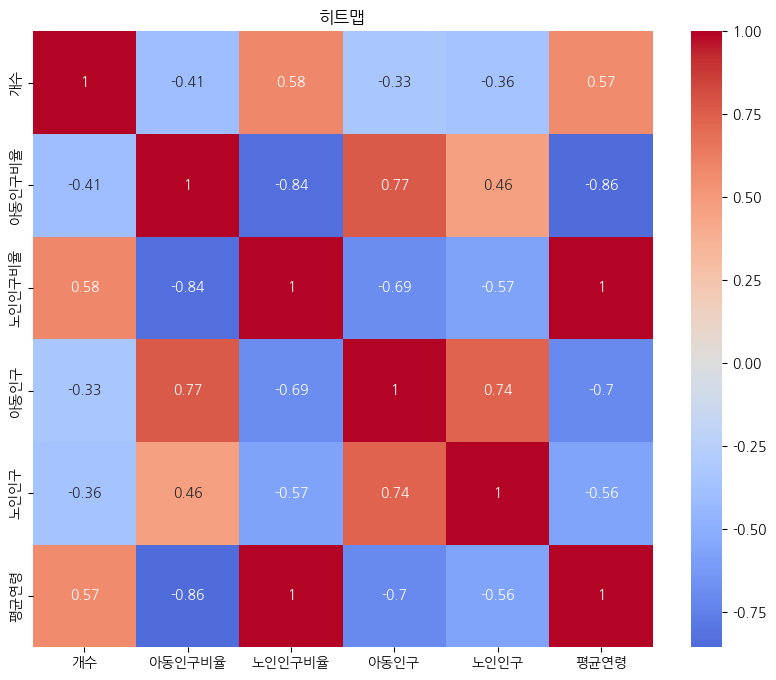

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(coef, annot=True, cmap='coolwarm', center=0)
plt.title('히트맵')
plt.show()

pairplot 함수를 활용한 산포도 시각화

개수, 아동인구비율, 노인인구비율, 아동인구비율, 노인인구 비율, 평균연령 변수에 대한 산포도 행렬을 그리는 동작 수행

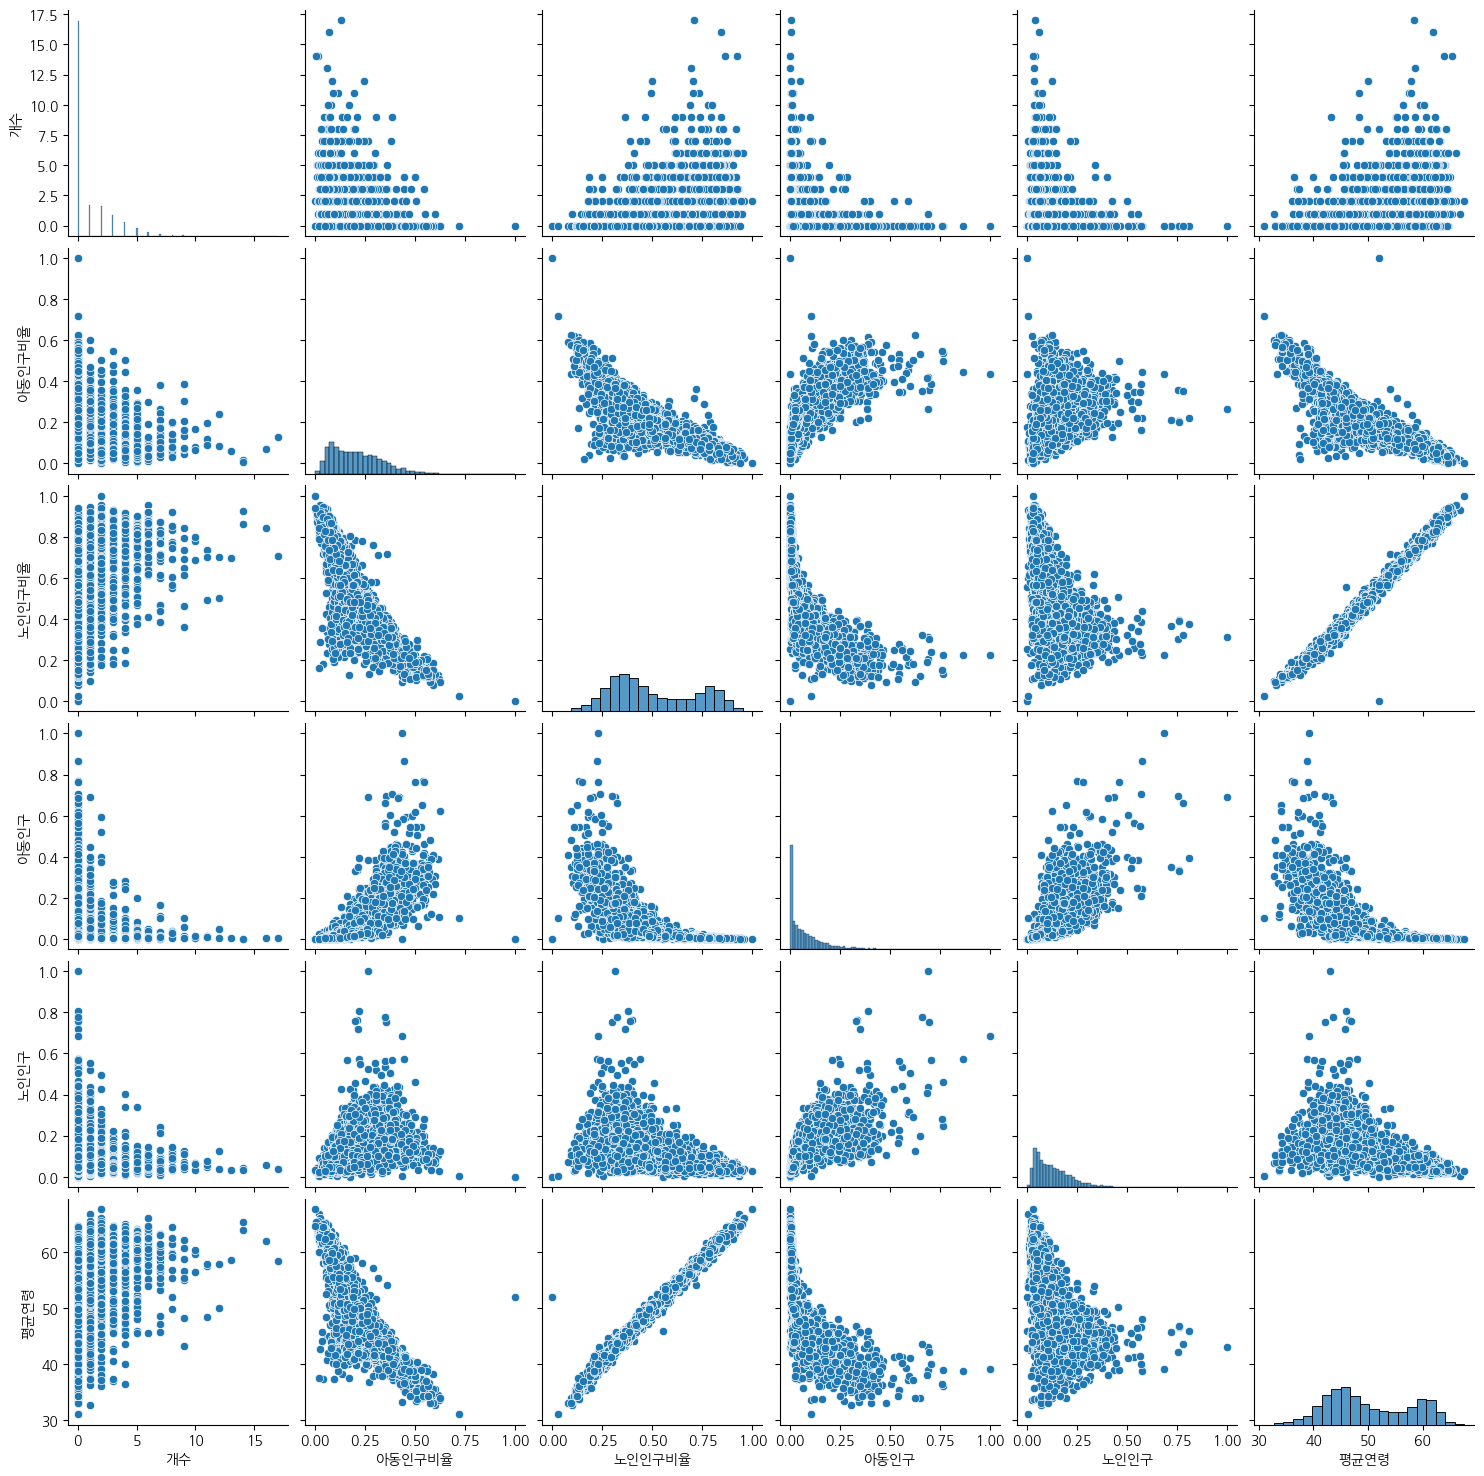

In [ ]:

# 데이터프레임에서 '개수', '아동인구비율', '노인인구비율' 열만 선택
data_to_plot = closed_popul_merged[['개수', '아동인구비율', '노인인구비율', '아동인구', '노인인구' , '평균연령']]

# pairplot 그리기
sns.pairplot(data_to_plot)
plt.show()

다중선형회귀분석

독립변수: 노인인구비율, 노인인구, 평균연령
종속변수: 개수


In [ ]:
import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = closed_popul_merged[['노인인구비율',  '노인인구', '평균연령']]
y = closed_popul_merged['개수']

# 상수항 추가
X = sm.add_constant(X)

# OLS(Ordinary Least Squares) 모델 생성
model = sm.OLS(y, X)

# 모델 학습
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     개수   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     616.4
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          9.49e-322
Time:                        08:21:41   Log-Likelihood:                -6206.2
No. Observations:                3509   AIC:                         1.242e+04
Df Residuals:                    3505   BIC:                         1.245e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7628      1.025      4.648      0.0

R-squared 값이 0.375로, 모델이 종속변수의 분산의 37.5%를 설명하고 있음을 의미

모든 독립변수가 P>|t|값이 0.05이하이므로, 변수들이 통계적으로 유의미함을 의미


독립변수의 계수
- 노인인구비율 3.6711->노인인구비율 1단위 증가 시 '개수'가 평균적으로 3.6711단위 증가함을 의미


모델의 Condition Number가 3.63e+03가 매우 커, 다중공선성이나 다른 수치적 문제가 있을 수 있음
- 다중공선성: 독립변수들 간에 높은 상관관계가 있는 상태로, 회귀 분석의 가정을 위반하여 계수의 추정치를 부정확하게 하거나 오버피티을 유발할 수 있음.

In [ ]:
import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = closed_popul_merged[['노인인구비율','노인인구']]
y = closed_popul_merged['개수']

# 상수항 추가
X = sm.add_constant(X)

# OLS(Ordinary Least Squares) 모델 생성
model = sm.OLS(y, X)

# 모델 학습
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     개수   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     898.3
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          1.05e-315
Time:                        08:21:41   Log-Likelihood:                -6223.7
No. Observations:                3509   AIC:                         1.245e+04
Df Residuals:                    3506   BIC:                         1.247e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2753      0.102    -12.523      0.0

In [ ]:
import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = closed_popul_merged[['평균연령']]
y = closed_popul_merged['개수']

# 상수항 추가
X = sm.add_constant(X)

# OLS(Ordinary Least Squares) 모델 생성
model = sm.OLS(y, X)

# 모델 학습
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     개수   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     1690.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          6.40e-302
Time:                        08:21:42   Log-Likelihood:                -6259.4
No. Observations:                3509   AIC:                         1.252e+04
Df Residuals:                    3507   BIC:                         1.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5951      0.161    -34.693      0.0

Prob 값이 0.00으로 회귀모델의 잔차가 정규성을 가지지 않음->회귀분석의 가정을 위반
Durbin-watson 통계량이 1.308->잔차들 간 자기상관일 가능성(시계열 데이터에서 흔히 발생)


상관관계 분석, 회귀 분석을 통하여 노인인구비율, 평균연령, 노인인구와 폐교수의 상관관계를 입증하였다. 이후로는 가중치 부여, 클러스터링을 활용한 입지 선정을 진행하고자 함

입지 선정이전에, 활용현황이 '미활용'인 폐교 목록을 활용한 데이터프레임 재구조화 필요

In [ ]:
unused_df = pd.read_excel("시도교육청_폐교목록_계.xlsx")[['시도교육청', '폐교명', '활용현황', '주소']]

unused_df['시군구'] = unused_df['주소'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(( '군', '구'))]))
unused_df['필요주소'] = unused_df['주소'].apply(lambda x: ' '.join([word for word in x.split() if word.endswith(('읍', '면', '동'))]))

unused_df = unused_df[unused_df['활용현황'] == '미활용']

print(unused_df)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


     시도교육청          폐교명 활용현황                  주소  시군구 필요주소
39      경남    (구)숭덕초등학교  미활용    거제시 둔덕면 술역리 28-3       둔덕면
59      경기    가납초 현암분교장  미활용   양주시 광적면 비암리 231-4       광적면
62      부산        가락중학교  미활용        강서구 죽림동 1090  강서구  죽림동
65      경남  가례초등학교갑을분교장  미활용   의령군 가례면 개승리 179-1  의령군  가례면
84      경북        가음중학교  미활용     의성군 가음면 장리 1276  의성군  가음면
...    ...          ...  ...                 ...  ...  ...
3875    전남     황전초평죽분교장  미활용   순천 황전면 평촌리 산193-1       황전면
3879    충남          황화초  미활용  논산시 연무읍 마전리 811-17       연무읍
3882    충북     회남초 분저분교  미활용      보은군 회남면 분저리 71  보은군  회남면
3889    전남      회천동초등학교  미활용      보성 회천면 서당리 659       회천면
3892    경남  회화초등학교동창분교장  미활용   고성군 회화면 어신리 937-1  고성군  회화면

[358 rows x 6 columns]


In [ ]:
unused_sum_df = unused_df.groupby(['시도교육청', '시군구','필요주소']).size().reset_index(name = '개수')
print(unused_sum_df)

    시도교육청  시군구 필요주소  개수
0      강원       근덕면   3
1      강원       노곡면   2
2      강원       도계읍   2
3      강원       문막읍   1
4      강원       미로면   2
..    ...  ...  ...  ..
277    충북  음성군  생극면   1
278    충북  음성군  음성읍   1
279    충북  진천군  이월면   1
280    충북  진천군  진천읍   1
281    충북  청원구  오창읍   1

[282 rows x 4 columns]


In [ ]:
unused_sum_df.rename(columns = {'시도교육청':'시도'}, inplace = True)


In [ ]:
merged_df = pd.read_excel("데이터합본.xlsx")

merged_df

,행정기관,필요주소,시군구,총 거주자수,노인인구,아동인구,노인인구비율,아동인구비율,시도,2018-2022노인인구변화율,평균연령,order,ADM_CD,geometry
0,서울특별시 종로구 청운효자동,청운효자동,종로구,"11,232",2911.0,1683.0,0.259170,0.149840,서울,-0.005128,45.0,0,11010720,POLYGON ((197412.7222077468 454597.00073025475...
1,서울특별시 종로구 사직동,사직동,종로구,"8,853",2474.0,1117.0,0.279453,0.126172,서울,0.010820,46.2,0,11010530,POLYGON ((197632.44728383512 452882.1948921889...
2,서울특별시 종로구 삼청동,삼청동,종로구,"2,208",791.0,247.0,0.358243,0.111866,서울,-0.046624,49.5,0,11010540,POLYGON ((198100.8479172179 453465.55813951907...
3,서울특별시 종로구 부암동,부암동,종로구,"8,977",2543.0,1205.0,0.283279,0.134232,서울,0.040184,46.4,0,11010550,POLYGON ((196551.44446990662 456090.8067518108...
4,서울특별시 종로구 평창동,평창동,종로구,"17,099",5027.0,2522.0,0.293994,0.147494,서울,0.100000,46.2,0,11010560,POLYGON ((197731.19344891456 458759.1752617769...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3507,제주특별자치도 서귀포시 중문동,중문동,NaN,"12,343",3042.0,2128.0,0.246455,0.172405,제주,0.211316,43.8,0,39020610,POLYGON ((150191.3170450318 -15003.09808824246...
3508,제주특별자치도 서귀포시 예래동,예래동,NaN,"3,804",1388.0,433.0,0.364879,0.113828,제주,0.175270,49.9,0,39020620,MULTIPOLYGON (((141492.09740520112 -29482.8065...
3509,서울특별시 강남구 일원2동,일원2동,NaN,NaN,NaN,NaN,NaN,NaN,서울,0.380823,NaN,0,11230740,POLYGON ((207303.57142147873 444195.3697293466...
3510,경기도 하남시 풍산동,풍산동,NaN,NaN,NaN,NaN,NaN,NaN,경기,0.821039,NaN,1,31180610,POLYGON ((217104.38449752587 450876.5499308863...


In [ ]:
unused_popul_merged = unused_sum_df.merge(merged_df, on = ['시도', '시군구', '필요주소'], how = 'outer')
unused_popul_merged['개수'].fillna(0, inplace = True)
unused_popul_merged

,시도,시군구,필요주소,개수,행정기관,총 거주자수,노인인구,아동인구,노인인구비율,아동인구비율,2018-2022노인인구변화율,평균연령,order,ADM_CD,geometry
0,강원,,근덕면,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,강원,,노곡면,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,강원,,도계읍,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,강원,,문막읍,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,강원,,미로면,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,제주,NaN,중문동,0.0,제주특별자치도 서귀포시 중문동,"12,343",3042.0,2128.0,0.246455,0.172405,0.211316,43.8,0.0,39020610.0,POLYGON ((150191.3170450318 -15003.09808824246...
3666,제주,NaN,예래동,0.0,제주특별자치도 서귀포시 예래동,"3,804",1388.0,433.0,0.364879,0.113828,0.175270,49.9,0.0,39020620.0,MULTIPOLYGON (((141492.09740520112 -29482.8065...
3667,서울,NaN,일원2동,0.0,서울특별시 강남구 일원2동,NaN,NaN,NaN,NaN,NaN,0.380823,NaN,0.0,11230740.0,POLYGON ((207303.57142147873 444195.3697293466...
3668,경기,NaN,풍산동,0.0,경기도 하남시 풍산동,NaN,NaN,NaN,NaN,NaN,0.821039,NaN,1.0,31180610.0,POLYGON ((217104.38449752587 450876.5499308863...


In [ ]:
# 결측치가 있는 행을 확인
missing_rows = unused_popul_merged[unused_popul_merged.isnull().any(axis=1)]

print(missing_rows.head(50))

# 결측치가 있는 행의 개수를 확인
missing_rows_count = unused_popul_merged.isnull().any(axis=1).sum()

print(f"결측치가 존재하는 행의 개수: {missing_rows_count}")
unused_popul_merged = unused_popul_merged.dropna()
print(unused_popul_merged)

    시도  시군구  필요주소   개수              행정기관  총 거주자수     노인인구    아동인구    노인인구비율  \
0   강원        근덕면  3.0               NaN     NaN      NaN     NaN       NaN   
1   강원        노곡면  2.0               NaN     NaN      NaN     NaN       NaN   
2   강원        도계읍  2.0               NaN     NaN      NaN     NaN       NaN   
3   강원        문막읍  1.0               NaN     NaN      NaN     NaN       NaN   
4   강원        미로면  2.0               NaN     NaN      NaN     NaN       NaN   
5   강원        부론면  1.0               NaN     NaN      NaN     NaN       NaN   
6   강원        북산면  1.0               NaN     NaN      NaN     NaN       NaN   
7   강원        사천면  1.0               NaN     NaN      NaN     NaN       NaN   
8   강원        연곡면  2.0               NaN     NaN      NaN     NaN       NaN   
9   강원        지정면  1.0               NaN     NaN      NaN     NaN       NaN   
10  강원        하장읍  1.0               NaN     NaN      NaN     NaN       NaN   
11  강원  고성군   현내면  1.0   강원특별자치도 고성군 현내면   2,222   1

In [ ]:
unused_popul_merged = unused_popul_merged[unused_popul_merged['개수'] != 0]

print(unused_popul_merged)

     시도  시군구 필요주소   개수              행정기관  총 거주자수    노인인구     아동인구    노인인구비율  \
54   경기  가평군   북면  1.0        경기도 가평군 북면   3,675  2026.0    273.0  0.551293   
55   경기  가평군  설악면  1.0       경기도 가평군 설악면   9,570  4210.0   1162.0  0.439916   
57   경기  양평군  양동면  1.0       경기도 양평군 양동면   4,553  2609.0    307.0  0.573029   
58   경기  양평군  청운면  1.0       경기도 양평군 청운면   3,792  2223.0    229.0  0.586234   
77   경남  거창군  남상면  1.0      경상남도 거창군 남상면   2,305  1417.0    110.0  0.614751   
..   ..  ...  ...  ...               ...     ...     ...      ...       ...   
277  충북  음성군  생극면  1.0      충청북도 음성군 생극면   4,428  2263.0    326.0  0.511066   
278  충북  음성군  음성읍  1.0      충청북도 음성군 음성읍  16,488  6540.0   1979.0  0.396652   
279  충북  진천군  이월면  1.0      충청북도 진천군 이월면   6,101  2853.0    468.0  0.467628   
280  충북  진천군  진천읍  1.0      충청북도 진천군 진천읍  30,032  8264.0   4777.0  0.275173   
281  충북  청원구  오창읍  1.0  충청북도 청주시 청원구 오창읍  68,357  9249.0  16253.0  0.135304   

       아동인구비율  2018-2022노인인구변화율  평균연령  order      A

In [ ]:
df_sorted = unused_popul_merged.sort_values(by='개수', ascending=False)

print(df_sorted)

     시도    시군구 필요주소   개수                행정기관  총 거주자수    노인인구     아동인구  \
104  경남    하동군  양보면  4.0        경상남도 하동군 양보면   1,608  1069.0     75.0   
239  전북    부안군  위도면  3.0        전라북도 부안군 위도면   1,098   645.0     54.0   
113  경남    합천군  봉산면  2.0        경상남도 합천군 봉산면   1,384   952.0     56.0   
92   경남  마산합포구  진전면  2.0  경상남도 창원시 마산합포구 진전면   3,681  2380.0    147.0   
268  충북    괴산군  청천면  2.0        충청북도 괴산군 청천면   5,125  3170.0    292.0   
..   ..    ...  ...  ...                 ...     ...     ...      ...   
108  경남    함양군  병곡면  1.0        경상남도 함양군 병곡면   1,274   746.0     79.0   
107  경남    함안군  여항면  1.0        경상남도 함안군 여항면     877   605.0     25.0   
105  경남    하동군  적량면  1.0        경상남도 하동군 적량면   1,837  1108.0    129.0   
103  경남    하동군  북천면  1.0        경상남도 하동군 북천면   1,585   963.0    101.0   
281  충북    청원구  오창읍  1.0    충청북도 청주시 청원구 오창읍  68,357  9249.0  16253.0   

       노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order      ADM_CD  \
104  0.664801  0.046642          0.058683  63.8    0.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
unused_popul_merged[['노인인구비율', '아동인구비율']] = scaler.fit_transform(unused_popul_merged[['노인인구비율', '아동인구비율']])

unused_popul_merged[['노인인구', '아동인구']] = scaler.fit_transform(unused_popul_merged[['노인인구', '아동인구']])

unused_popul_merged[['2018-2022노인인구변화율']] = scaler.fit_transform(unused_popul_merged[['2018-2022노인인구변화율']])
print(unused_popul_merged)

     시도  시군구 필요주소   개수              행정기관  총 거주자수      노인인구      아동인구  \
54   경기  가평군   북면  1.0        경기도 가평군 북면   3,675  0.120869  0.015404   
55   경기  가평군  설악면  1.0       경기도 가평군 설악면   9,570  0.269087  0.070179   
57   경기  양평군  양동면  1.0       경기도 양평군 양동면   4,553  0.160434  0.017498   
58   경기  양평군  청운면  1.0       경기도 양평군 청운면   3,792  0.134238  0.012693   
77   경남  거창군  남상면  1.0      경상남도 거창군 남상면   2,305  0.079539  0.005360   
..   ..  ...  ...  ...               ...     ...       ...       ...   
277  충북  음성군  생극면  1.0      충청북도 음성군 생극면   4,428  0.136953  0.018669   
278  충북  음성군  음성읍  1.0      충청북도 음성군 음성읍  16,488  0.427214  0.120518   
279  충북  진천군  이월면  1.0      충청북도 진천군 이월면   6,101  0.176994  0.027418   
280  충북  진천군  진천읍  1.0      충청북도 진천군 진천읍  30,032  0.544214  0.292914   
281  충북  청원구  오창읍  1.0  충청북도 청주시 청원구 오창읍  68,357  0.611062  1.000000   

       노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order      ADM_CD  \
54   0.666062  0.242332          0.567947  57.4    0.0  31570350.

**가중치 부여**

정규화한 값에 따라, 0.1간격으로 가중치 부여

In [ ]:
# 가중치 함수 정의
def assign_weight(value):
    if value < 0.1:
        return 1
    elif value < 0.2:
        return 2
    elif value < 0.3:
        return 3
    elif value < 0.4:
        return 4
    elif value < 0.5:
        return 5
    elif value < 0.6:
        return 6
    elif value < 0.7:
        return 7
    elif value < 0.8:
        return 8
    elif value < 0.9:
        return 9
    else:
        return 10

# 가중치(인구수) 열 생성
unused_popul_merged['가중치(인구수)'] = unused_popul_merged['노인인구'].apply(lambda x: assign_weight(x) * 3)

# 가중치(비율) 열 생성
unused_popul_merged['가중치(비율)'] = unused_popul_merged['노인인구비율'].apply(assign_weight)

unused_popul_merged['가중치(변화율)'] = unused_popul_merged['2018-2022노인인구변화율'].apply(assign_weight)

# 결과 출력
print(unused_popul_merged)

     시도  시군구 필요주소   개수              행정기관  총 거주자수      노인인구      아동인구  \
54   경기  가평군   북면  1.0        경기도 가평군 북면   3,675  0.120869  0.015404   
55   경기  가평군  설악면  1.0       경기도 가평군 설악면   9,570  0.269087  0.070179   
57   경기  양평군  양동면  1.0       경기도 양평군 양동면   4,553  0.160434  0.017498   
58   경기  양평군  청운면  1.0       경기도 양평군 청운면   3,792  0.134238  0.012693   
77   경남  거창군  남상면  1.0      경상남도 거창군 남상면   2,305  0.079539  0.005360   
..   ..  ...  ...  ...               ...     ...       ...       ...   
277  충북  음성군  생극면  1.0      충청북도 음성군 생극면   4,428  0.136953  0.018669   
278  충북  음성군  음성읍  1.0      충청북도 음성군 음성읍  16,488  0.427214  0.120518   
279  충북  진천군  이월면  1.0      충청북도 진천군 이월면   6,101  0.176994  0.027418   
280  충북  진천군  진천읍  1.0      충청북도 진천군 진천읍  30,032  0.544214  0.292914   
281  충북  청원구  오창읍  1.0  충청북도 청주시 청원구 오창읍  68,357  0.611062  1.000000   

       노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order      ADM_CD  \
54   0.666062  0.242332          0.567947  57.4    0.0  31570350.

In [ ]:
def assign_weight_age(age):
    if 37.1 <= age <= 40.5:
        return 1
    elif 40.6 <= age <= 44.0:
        return 2
    elif 44.1 <= age <= 47.5:
        return 3
    elif 47.6 <= age <= 51.0:
        return 4
    elif 51.1 <= age <= 54.5:
        return 5
    elif 54.6 <= age <= 58.0:
        return 6
    elif 58.1 <= age <= 61.5:
        return 7
    elif 61.6 <= age <= 65.0:
        return 8
    else:
        return 9

unused_popul_merged['가중치(평균연령)'] = unused_popul_merged['평균연령'].apply(assign_weight_age)

print(unused_popul_merged)

     시도  시군구 필요주소   개수              행정기관  총 거주자수      노인인구      아동인구  \
54   경기  가평군   북면  1.0        경기도 가평군 북면   3,675  0.120869  0.015404   
55   경기  가평군  설악면  1.0       경기도 가평군 설악면   9,570  0.269087  0.070179   
57   경기  양평군  양동면  1.0       경기도 양평군 양동면   4,553  0.160434  0.017498   
58   경기  양평군  청운면  1.0       경기도 양평군 청운면   3,792  0.134238  0.012693   
77   경남  거창군  남상면  1.0      경상남도 거창군 남상면   2,305  0.079539  0.005360   
..   ..  ...  ...  ...               ...     ...       ...       ...   
277  충북  음성군  생극면  1.0      충청북도 음성군 생극면   4,428  0.136953  0.018669   
278  충북  음성군  음성읍  1.0      충청북도 음성군 음성읍  16,488  0.427214  0.120518   
279  충북  진천군  이월면  1.0      충청북도 진천군 이월면   6,101  0.176994  0.027418   
280  충북  진천군  진천읍  1.0      충청북도 진천군 진천읍  30,032  0.544214  0.292914   
281  충북  청원구  오창읍  1.0  충청북도 청주시 청원구 오창읍  68,357  0.611062  1.000000   

       노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order      ADM_CD  \
54   0.666062  0.242332          0.567947  57.4    0.0  31570350.

In [ ]:
from sklearn.cluster import KMeans

# 독립변수
X = unused_popul_merged[['노인인구비율', '노인인구', '평균연령', '개수']]

# KMeans 모델을 학습
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

# 클러스터 레이블을 데이터프레임에 추가
unused_popul_merged['cluster'] = kmeans.labels_

print(unused_popul_merged.head(30))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


     시도    시군구 필요주소   개수                행정기관  총 거주자수      노인인구      아동인구  \
54   경기    가평군   북면  1.0          경기도 가평군 북면   3,675  0.120869  0.015404   
55   경기    가평군  설악면  1.0         경기도 가평군 설악면   9,570  0.269087  0.070179   
57   경기    양평군  양동면  1.0         경기도 양평군 양동면   4,553  0.160434  0.017498   
58   경기    양평군  청운면  1.0         경기도 양평군 청운면   3,792  0.134238  0.012693   
77   경남    거창군  남상면  1.0        경상남도 거창군 남상면   2,305  0.079539  0.005360   
78   경남    거창군  신원면  1.0        경상남도 거창군 신원면   1,519  0.054021  0.003019   
79   경남    거창군  주상면  1.0        경상남도 거창군 주상면   1,511  0.050628  0.003081   
80   경남    고성군  동해면  2.0        경상남도 고성군 동해면   3,072  0.105667  0.008811   
81   경남    고성군  삼산면  1.0        경상남도 고성군 삼산면   1,718  0.056328  0.004929   
82   경남    고성군  상리면  1.0        경상남도 고성군 상리면   1,584  0.051578  0.002896   
83   경남    고성군  영오면  1.0        경상남도 고성군 영오면   1,378  0.038887  0.003882   
84   경남    고성군  하일면  1.0        경상남도 고성군 하일면   1,792  0.060943  0.005669   
85   경남    고

In [ ]:
output_file_path = "클러스터링 적용.xlsx"

# 데이터프레임을 Excel 파일로 저장
unused_popul_merged.to_excel(output_file_path, index=False)

In [ ]:
df_sorted = unused_popul_merged.sort_values(by='cluster', ascending=False)

df_sorted

,시도,시군구,필요주소,개수,행정기관,총 거주자수,노인인구,아동인구,노인인구비율,아동인구비율,2018-2022노인인구변화율,평균연령,order,ADM_CD,geometry,가중치(인구수),가중치(비율),가중치(변화율),가중치(평균연령),cluster
158,경북,영덕군,영덕읍,1.0,경상북도 영덕군 영덕읍,"10,390",0.256261,0.089464,0.403015,0.555991,0.294606,50.2,0.0,37550110.0,MULTIPOLYGON (((417283.3922488454 324953.94414...,9,5,3,4,4
278,충북,음성군,음성읍,1.0,충청북도 음성군 음성읍,"16,488",0.427214,0.120518,0.418458,0.454323,0.602877,50.8,0.0,33570110.0,POLYGON ((257405.67173772413 387611.6487563954...,15,5,7,4,4
162,경북,울진군,죽변면,1.0,경상북도 울진군 죽변면,"6,084",0.160706,0.033949,0.471032,0.335303,0.512760,52.5,0.0,37620370.0,MULTIPOLYGON (((414730.70254511724 395973.0664...,6,5,6,5,4
254,충남,동남구,병천면,1.0,충청남도 천안시 동남구 병천면,"6,205",0.155344,0.030253,0.437237,0.281961,0.576886,51.8,0.0,34011360.0,POLYGON ((227600.23330383238 373069.5644693952...,6,5,6,5,4
55,경기,가평군,설악면,1.0,경기도 가평군 설악면,"9,570",0.269087,0.070179,0.487731,0.460786,0.867901,51.7,0.0,31570310.0,POLYGON ((249463.81725544983 468722.8532931939...,9,5,9,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,충남,금산군,복수면,1.0,충청남도 금산군 복수면,"2,896",0.095555,0.010043,0.697276,0.195712,0.498213,58.9,0.0,34510380.0,POLYGON ((233468.42174582474 308004.9917330034...,3,7,5,7,0
103,경남,하동군,북천면,1.0,경상남도 하동군 북천면,"1,585",0.048728,0.004806,0.756172,0.193375,0.200155,61.1,0.0,38560400.0,POLYGON ((277289.7447494723 184917.87391934148...,3,8,3,7,0
101,경남,창녕군,도천면,1.0,경상남도 창녕군 도천면,"2,570",0.080149,0.008811,0.671780,0.197403,0.497327,58.1,0.0,38530400.0,POLYGON ((342548.3963133341 218498.41064960137...,3,7,5,7,0
94,경남,산청군,단성면,2.0,경상남도 산청군 단성면,"5,588",0.203325,0.016944,0.712015,0.145204,0.525634,59.7,1.0,38570370.0,"POLYGON ((281945.63579897623 207593.287494087,...",9,8,6,7,0


클러스터링 결과

- 0
노인인구 비율 높음. 노인인구수도 상대적으로 많음(고령화 진행 중)

- 1
노인인구 비율 높음. 노인인구 수 낮음

- 2
노인인구 비율 낮음. 노인인구 수 적음

- 3
노인인구 비율 노인인구 수 중간치

- 4
노인인구 비율 노인인구 수 낮음

- 5
노인인구 비율 높음. 노인인구 수 매우 많음

- 6
노인인구 비율 노인인구 수 중간치

In [ ]:
df_filtered = unused_popul_merged[(unused_popul_merged['cluster'] == 1) ]

In [ ]:
print(df_filtered)

     시도    시군구 필요주소   개수                행정기관  총 거주자수      노인인구      아동인구  \
93   경남  마산회원구  내서읍  1.0  경상남도 창원시 마산회원구 내서읍  61,039  1.000000  0.673752   
170  서울    광진구  화양동  1.0       서울특별시 광진구 화양동  23,023  0.200204  0.056808   
173  울산    울주군  온양읍  1.0       울산광역시 울주군 온양읍  27,985  0.429522  0.314356   
280  충북    진천군  진천읍  1.0        충청북도 진천군 진천읍  30,032  0.544214  0.292914   
281  충북    청원구  오창읍  1.0    충청북도 청주시 청원구 오창읍  68,357  0.611062  1.000000   

       노인인구비율    아동인구비율  2018-2022노인인구변화율  평균연령  order      ADM_CD  \
93   0.176307  0.730072          0.897491  44.0    0.0  38114110.0   
170  0.005556  0.088279          0.308971  37.3    0.0  11050530.0   
173  0.159487  0.746800          1.000000  43.6    0.0  26510130.0   
280  0.223952  0.635244          0.685883  45.3    0.0  33550110.0   
281  0.000000  1.000000          0.844008  37.1    0.0  33044120.0   

                                              geometry  가중치(인구수)  가중치(비율)  \
93   POLYGON ((341657.104980699 198636.446678

In [ ]:
df_filtered['가중치(합)'] = df_filtered[['가중치(인구수)', '가중치(비율)', '가중치(변화율)', '가중치(평균연령)']].sum(axis=1)

<ipython-input-185-e2f159784946>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['가중치(합)'] = df_filtered[['가중치(인구수)', '가중치(비율)', '가중치(변화율)', '가중치(평균연령)']].sum(axis=1)


In [ ]:
print(df_filtered)

     시도    시군구 필요주소   개수                행정기관  총 거주자수      노인인구      아동인구  \
93   경남  마산회원구  내서읍  1.0  경상남도 창원시 마산회원구 내서읍  61,039  1.000000  0.673752   
170  서울    광진구  화양동  1.0       서울특별시 광진구 화양동  23,023  0.200204  0.056808   
173  울산    울주군  온양읍  1.0       울산광역시 울주군 온양읍  27,985  0.429522  0.314356   
280  충북    진천군  진천읍  1.0        충청북도 진천군 진천읍  30,032  0.544214  0.292914   
281  충북    청원구  오창읍  1.0    충청북도 청주시 청원구 오창읍  68,357  0.611062  1.000000   

       노인인구비율    아동인구비율  ...  평균연령  order      ADM_CD  \
93   0.176307  0.730072  ...  44.0    0.0  38114110.0   
170  0.005556  0.088279  ...  37.3    0.0  11050530.0   
173  0.159487  0.746800  ...  43.6    0.0  26510130.0   
280  0.223952  0.635244  ...  45.3    0.0  33550110.0   
281  0.000000  1.000000  ...  37.1    0.0  33044120.0   

                                              geometry 가중치(인구수)  가중치(비율)  \
93   POLYGON ((341657.104980699 198636.44667810202,...       30        2   
170  POLYGON ((206157.39353063828 449527.9135512

In [ ]:
df_filtered = df_filtered.sort_values(by='가중치(합)', ascending=False)
top_5 = df_filtered.head(10)
print(top_5)

     시도    시군구 필요주소   개수                행정기관  총 거주자수      노인인구      아동인구  \
93   경남  마산회원구  내서읍  1.0  경상남도 창원시 마산회원구 내서읍  61,039  1.000000  0.673752   
281  충북    청원구  오창읍  1.0    충청북도 청주시 청원구 오창읍  68,357  0.611062  1.000000   
280  충북    진천군  진천읍  1.0        충청북도 진천군 진천읍  30,032  0.544214  0.292914   
173  울산    울주군  온양읍  1.0       울산광역시 울주군 온양읍  27,985  0.429522  0.314356   
170  서울    광진구  화양동  1.0       서울특별시 광진구 화양동  23,023  0.200204  0.056808   

       노인인구비율    아동인구비율  ...  평균연령  order      ADM_CD  \
93   0.176307  0.730072  ...  44.0    0.0  38114110.0   
281  0.000000  1.000000  ...  37.1    0.0  33044120.0   
280  0.223952  0.635244  ...  45.3    0.0  33550110.0   
173  0.159487  0.746800  ...  43.6    0.0  26510130.0   
170  0.005556  0.088279  ...  37.3    0.0  11050530.0   

                                              geometry 가중치(인구수)  가중치(비율)  \
93   POLYGON ((341657.104980699 198636.44667810202,...       30        2   
281  POLYGON ((244667.81697279616 364386.5837011

클러스터링 후 가중치 합을 계산하여 상위 5개를 출력한 결과

1. 경남 마산회원구 내서읍 - 중리 초등학교 안평분교장(1999)
2. 충북 진천군 진천읍 - 성암초 연곡분교(1991)
3. 충남 태안군 소원면 - 소원초 의항분교장(2023)
4. 울산 울주군 온양읍 - 삼광분교(1999)
5. 충북 괴산군 청천면 - 청천초 대후분교장(1993), 청천초 신월분교장(2007)